In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime

In [3]:
import yfinance

In [4]:
!pip install --upgrade yfinance

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/huggingface_hub-0.29.2-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


## Loading SP500 stock prices data

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'VLTO', 'SOLV', 'SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [7]:
df.head()

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-29 A       31.251013  33.740002  34.060001  33.240002  33.360001   
           AAPL    24.536383  27.264999  28.377501  26.965000  28.207500   
           ABBV    35.061211  52.790001  54.189999  51.880001  53.099998   
           ABT     32.820751  39.500000  40.150002  39.029999  39.259998   
           ACGL    23.217773  24.416668  24.456667  24.100000  24.170000   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0

## Calculating different features

* Garman-Klass Volatility
* Dollar Volume
* MACD
* RSI
* Bollinger Bands
* ATR

In [9]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6



In [10]:
#Checking the first 25 RSI values.
#length=20 ==> Calculate the RSI using the past 20 data points (typically 20 trading days if it’s daily data)
ticker = 'AAPL'  # Change this to your desired ticker

# Extract data for the ticker
df_ticker = df.xs(ticker, level='ticker')

# Select RSI column and first 20 rows
rsi_first_20 = df_ticker['rsi'].head(25)

print(rsi_first_20)


date
2015-09-29          NaN
2015-09-30          NaN
2015-10-01          NaN
2015-10-02          NaN
2015-10-05          NaN
2015-10-06          NaN
2015-10-07          NaN
2015-10-08          NaN
2015-10-09          NaN
2015-10-12          NaN
2015-10-13          NaN
2015-10-14          NaN
2015-10-15          NaN
2015-10-16          NaN
2015-10-19          NaN
2015-10-20          NaN
2015-10-21          NaN
2015-10-22          NaN
2015-10-23          NaN
2015-10-26          NaN
2015-10-27    58.972564
2015-10-28    67.820208
2015-10-29    69.658838
2015-10-30    66.394543
2015-11-02    68.896955
Name: rsi, dtype: float64


## Resample the data to the monthly level and, for each month, select the top 150 most liquid stocks.

In [12]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]  #all these are time series columns, taking the last value- 
                                                                                    #for a month wouldn't make sense

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), #taking the monthly mean for dollar volume
                   df.unstack()[last_cols].resample('M').last().stack('ticker')], #taking the last value in the month,which is the most recent value in the -
                  axis=1)).dropna()                                               #month for the technical indicators

data.head()

dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2015-11-30 A          134.988346  38.734947         -0.002430  73.421662   
           AAPL      4005.252713  26.729136         -0.003654  55.537364   
           ABBV       325.730933  38.977577         -0.070930  49.376892   
           ABT        207.499330  37.540981         -0.013992  56.962513   
           ACGL        28.174423  22.970539         -0.001121  35.682522   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.538792  3.611226  3.683660 -1.033887  0.567158  
           AAPL    3.277189  3.320493  3.363797 -0.967900 -0.142789  
           ABBV    3.691885  3.740093  3.788300 -0.526809  0.145677  
           ABT     3.636725  3.658567  3.680410 -1.064842  0.335556  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166

Compute the 5-year rolling average of dollar volume for each stock, and use it to identify the most liquid stocks before applying the filtering step.

In [14]:

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
# min_periods=12 → at least 12 months of data is required to compute a value
# Window size: 5*12 = 60 months → up to 5 years of history used

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.090456         -0.002767  49.891070  3.289745   
           ABBV     38.834358         -0.056807  27.477756  3.718614   
           ABT      33.619495         -0.009785  38.008869  3.535356   
           ACN     101.760162         -0.006263  53.823667  4.619889   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.318620  3.347494 -1.038688 -0.195978  
           ABBV    3.772733  3.826853 -0.893132 -0.760594  
           ABT     3.585802  3.636249 -1.035224 -0.650888  
           ACN     4.631525  4.643160 -0.996806 -0.135456  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 CRWD    5.103696  5.181204 -0.744862  0.245950  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           DASH    4.403906  4.478620 -1.145418 -0.117919  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  
           COIN    4.378785  4.483998 -1.183735  0.049978  

[12516 rows x 8 columns]

## Calculate Monthly Returns Across Multiple Time Horizons

To capture the time-series dynamics and patterns such as momentum effects, we compute historical returns over different monthly intervals. This is done using the .pct_change(lag) method, which calculates the percentage change in price over varying lag periods.

In [16]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff))) #Extremely low/high returns are clipped
                              .add(1) # turn return into a growth factor
                              .pow(1/lag)  # annualization trick in reverse — converts lag return to a monthly equivalent rate
                              .sub(1)) # turn the growth factor back into a percentage return
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.529034         -0.001263  69.196721  3.590193   
           ABBV     65.125320         -0.042702  55.247895  4.161565   
           ABT      47.540337         -0.007128  53.844859  3.873128   
           ACN     127.138969         -0.005423  69.365505  4.785195   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.637059  3.683926 -0.906642 -0.039275   0.096808   
           ABBV    4.207901  4.254238  0.375557  0.473815   0.022728   
           ABT     3.896688  3.920248 -1.040044  0.276133   0.021275   
           ACN     4.824869  4.864543 -0.986514  0.352342   0.064180   
           ADBE    5.089292  5.226825 -0.888269  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           DASH    4.403906  4.478620 -1.145418 -0.117919  -0.113515   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   
           COIN    4.378785  4.483998 -1.183735  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10341 rows x 14 columns]

## Incorporate Fama–French Factors and Compute Rolling Factor Betas

To assess each asset’s exposure to systematic risk, we integrate the Fama–French factors and estimate rolling factor betas using linear regression.

The five Fama–French factors — market risk, size, value, profitability, and investment — have been empirically proven to explain a significant portion of asset returns. These factors are widely used in finance to evaluate the risk and return characteristics of securities and portfolios.

We retrieve historical factor returns via pandas-datareader and use rolling linear regressions (via RollingOLS) to estimate time-varying exposures (betas) to each factor. These rolling betas are then incorporated as financial features for modeling.

In [18]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

# So for every stock per month, now we have:
# 	•	The stock’s 1-month forward return
# 	•	The market conditions (FF 5 factors) during that month

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021275
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.056890
           WDAY   -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0188 -0.0078   0.046947

[10341 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [20]:
# soon be running rolling regressions, and this ensures we’re not trying to regress on stocks with too few observations, which could cause:
# 	•	Unstable estimates
# 	•	Errors or warnings


observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021275
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.056890
           WDAY   -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0188 -0.0078  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0188 -0.0078   0.046947

[10320 rows x 6 columns]

Calculate Rolling Factor Betas

In [22]:
# Each beta represents how sensitive a stock’s return is to a specific Fama–French factor.

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.333025 -0.166382  0.273855  0.318327  0.101466
           WDAY    1.080795 -0.944134 -0.563279 -0.904136 -0.246177
           WFC     1.122264  0.241198  2.052226 -0.499449 -1.543491
           WMT     0.703724 -0.315174 -0.403859 -0.144835  0.499222
           XOM     0.983254 -1.133635  1.727816 -0.687823 -0.356364

[10320 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [24]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10126 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10126 non-null  float64
 1   rsi               10126 non-null  float64
 2   bb_low            10126 non-null  float64
 3   bb_mid            10126 non-null  float64
 4   bb_high           10126 non-null  float64
 5   atr               10126 non-null  float64
 6   macd              10126 non-null  float64
 7   return_1m         10126 non-null  float64
 8   return_2m         10126 non-null  float64
 9   return_3m         10126 non-null  float64
 10  return_6m         10126 non-null  float64
 11  return_9m         10126 non-null  float64
 12  return_12m        10126 non-null  float64
 13  Mkt-RF            10126 non-null  float64
 14  SMB               10126 non-null  float64
 15  HML      

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [26]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001263  69.196721  3.590193  3.637059  3.683926   
           ABBV           -0.042702  55.247895  4.161565  4.207901  4.254238   
           ABT            -0.007128  53.844859  3.873128  3.896688  3.920248   
           ACN            -0.005423  69.365505  4.785195  4.824869  4.864543   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000186  54.722524  3.974950  3.992416  4.009883   
           XOM            -0.001011  59.440184  4.653137  4.693220  4.733304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276571 -0.251243   
           ABBV     0.056495   0.047273    0.044026  0.505457  0.360911   
           ABT      0.038672   0.031320    0.029294  0.833397 -0.194768   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154549   
           ADBE     0.045993   0.049515    0.041515  1.109844 -0.318351   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743557 -0.259226   
           XOM      0.012838   0.008747    0.027037  1.007000 -1.089040   
           MRNA    -0.071952  -0.064976   -0.015431  1.153082  0.830491   
           UBER     0.057244   0.066838    0.043691  1.089140  1.123820   
           CRWD     0.026391   0.047942   -0.002216  0.596069 -0.983458   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610483  0.680486  0.488789        2  
           ABBV   -0.030511  0.179041  0.188214        0  
           ABT    -0.528561  0.255634  0.985798        0  
           ACN    -0.339659  0.270195  0.196830        2  
           ADBE   -0.184551 -0.218162 -0.687480        2  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.508948 -0.128718  0.631455        3  
           XOM     1.679912 -0.722018 -0.271997        3  
           MRNA   -1.184026  0.623413  1.031253        1  
           UBER   -0.230611 -1.531531 -0.492785        0  
           CRWD   -0.701906 -2.504523 -0.806878        3  

[10126 rows x 19 columns]

In [49]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')   #we're plotting atr(x axis) and rsi(yaxis) columns
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


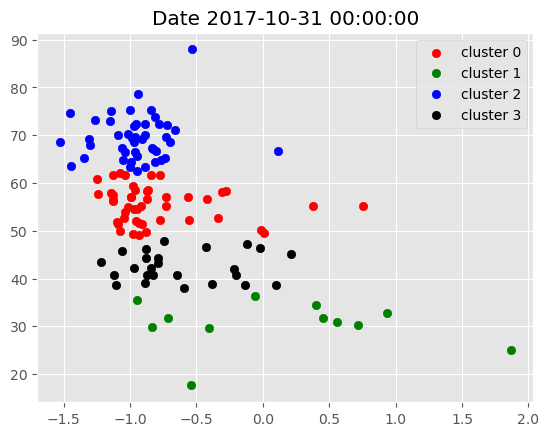

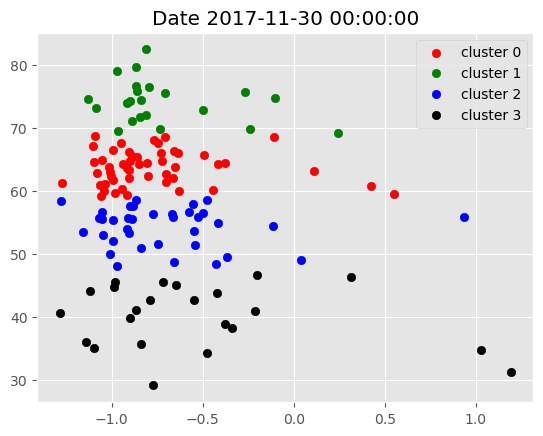

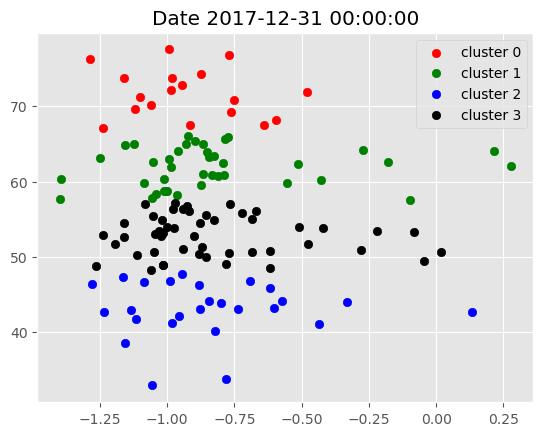

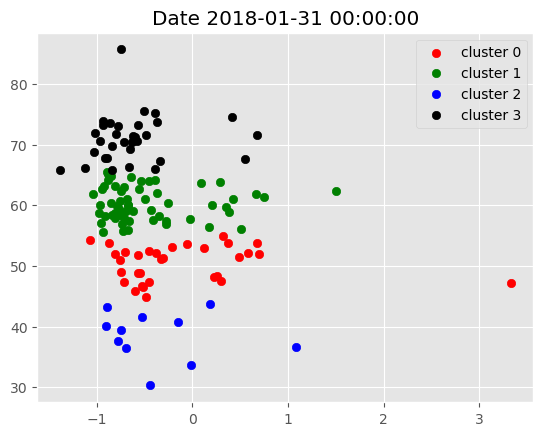

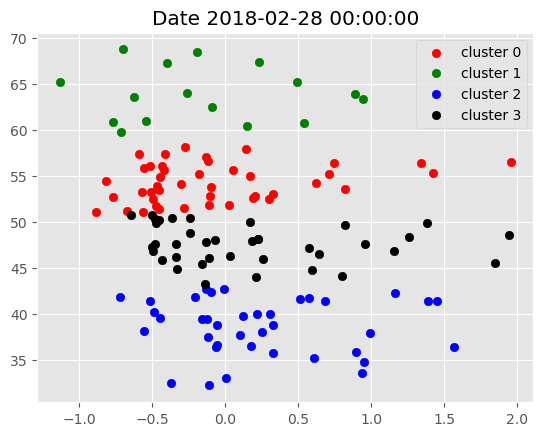

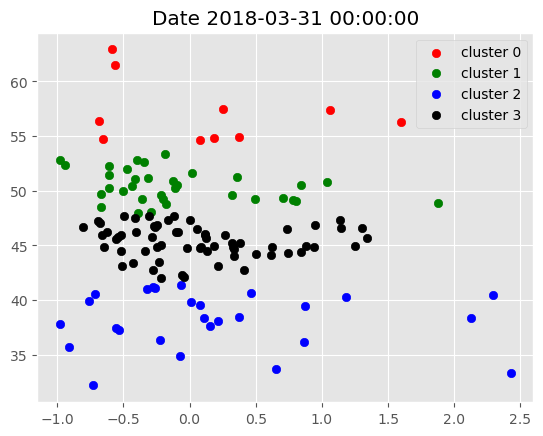

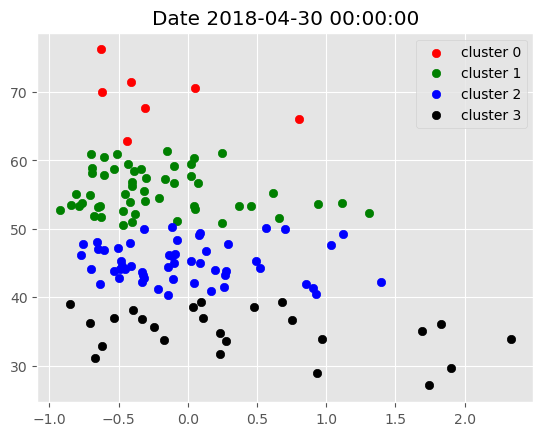

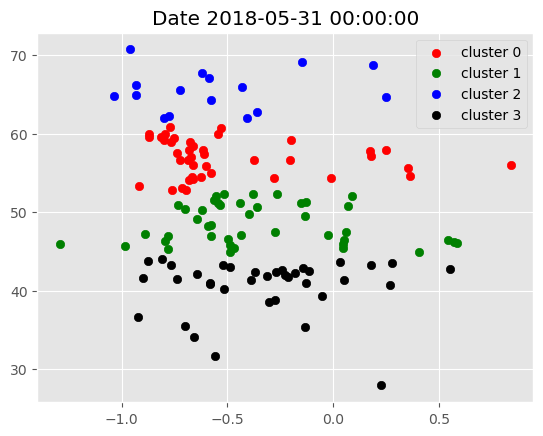

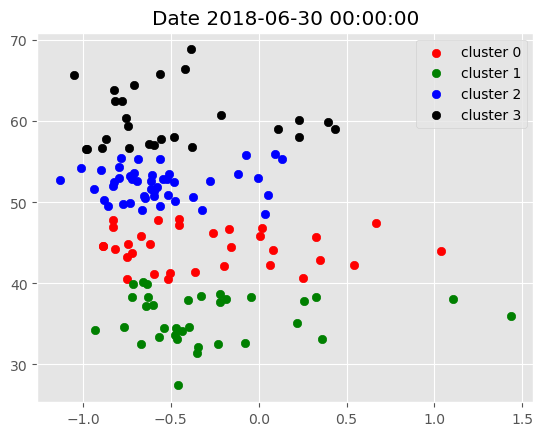

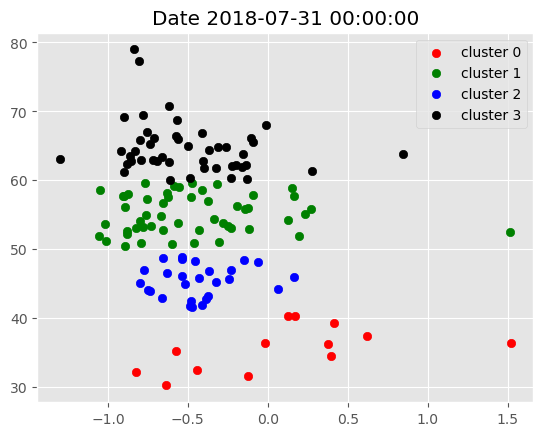

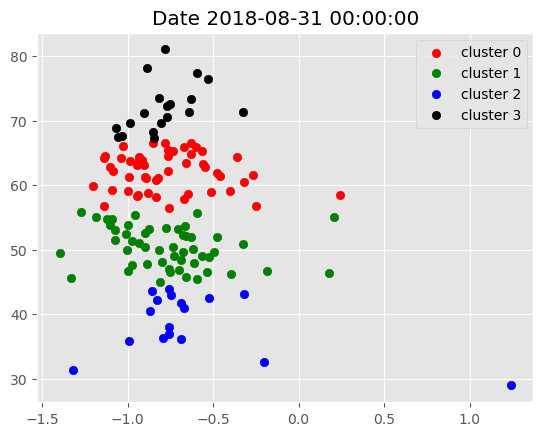

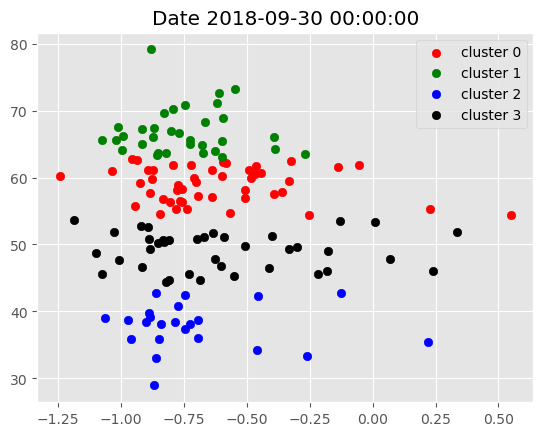

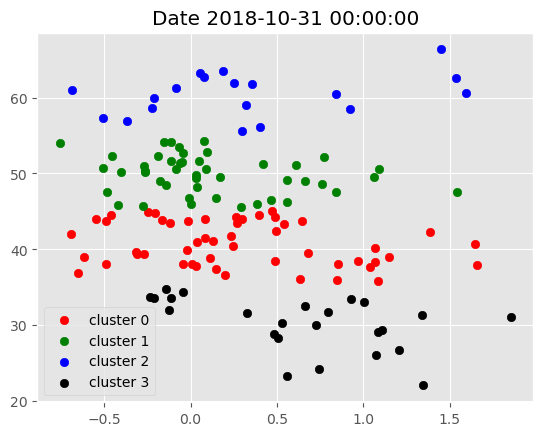

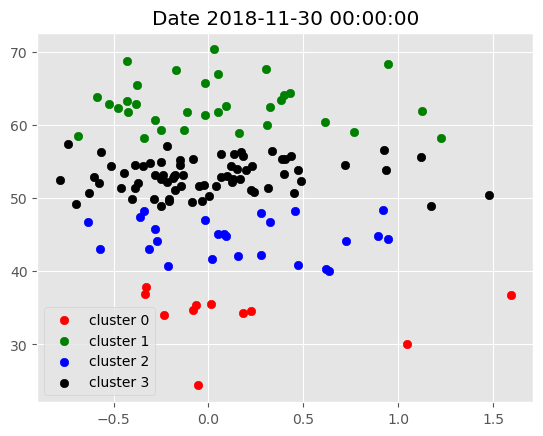

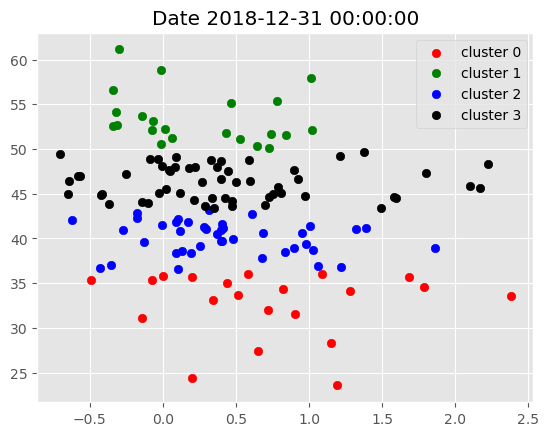

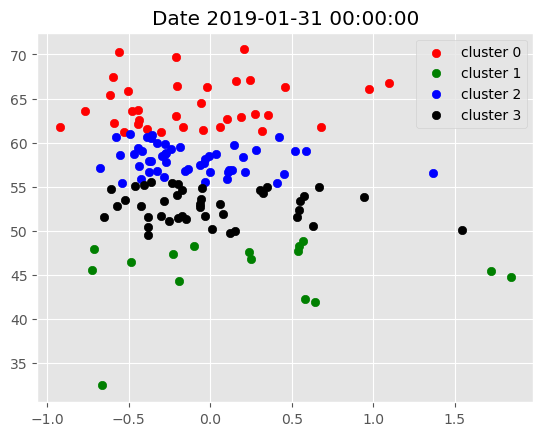

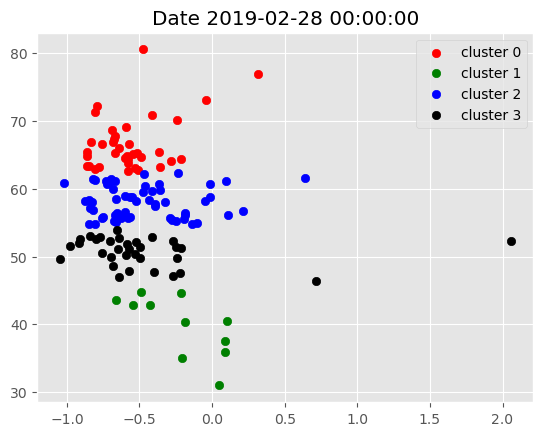

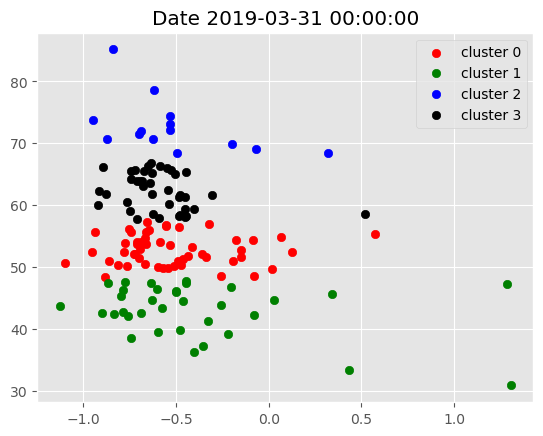

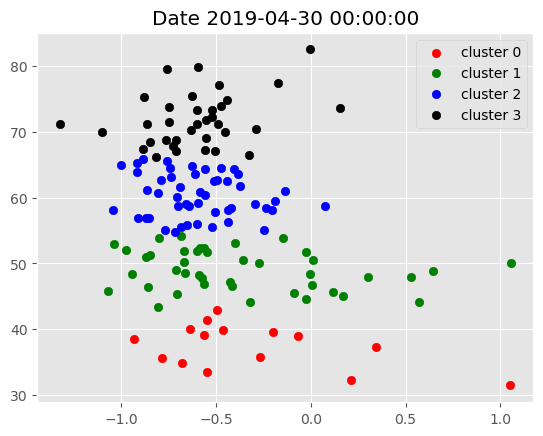

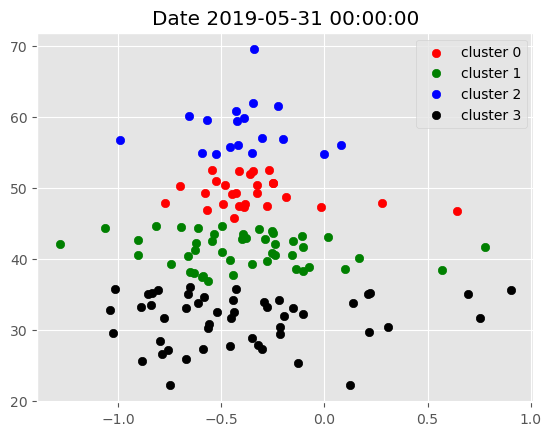

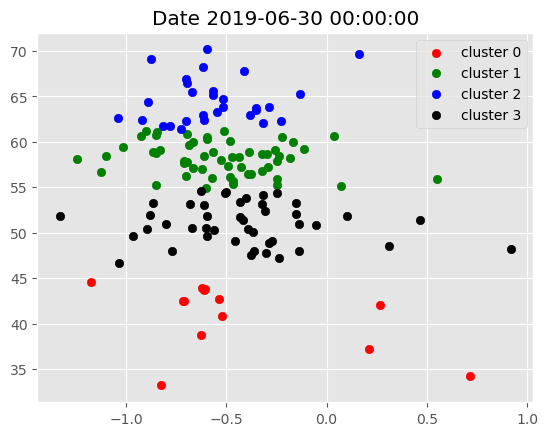

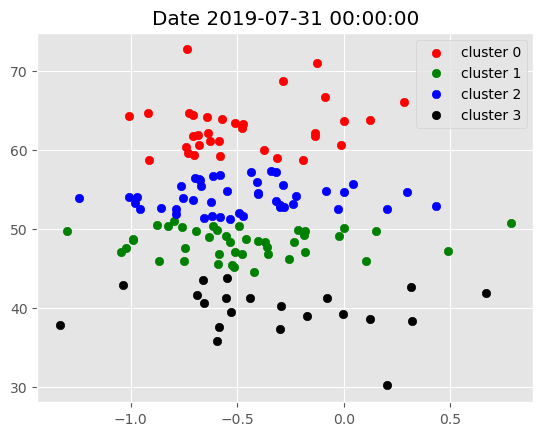

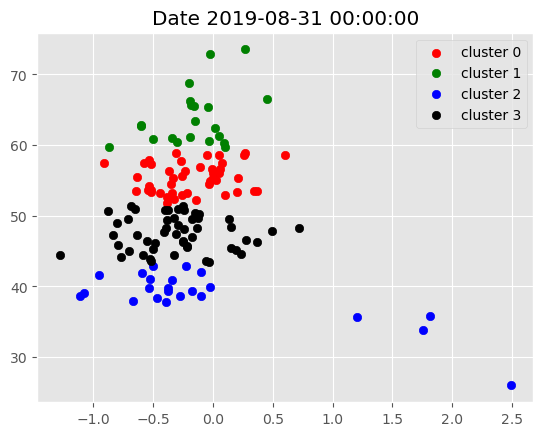

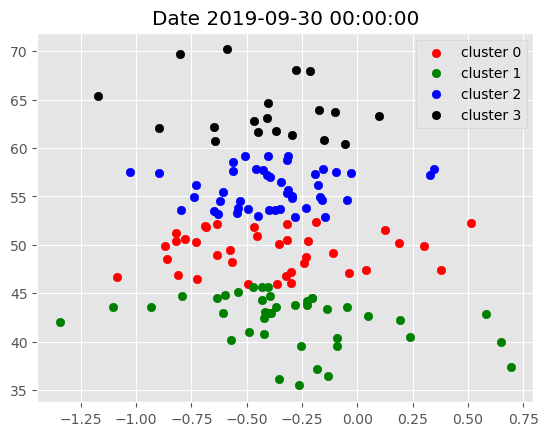

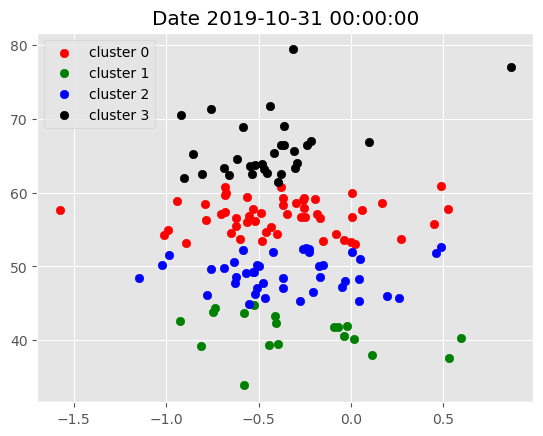

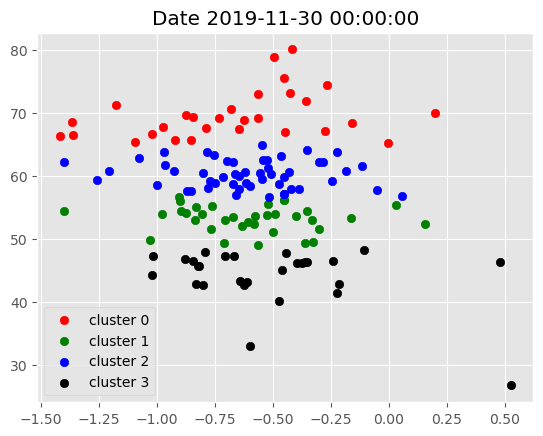

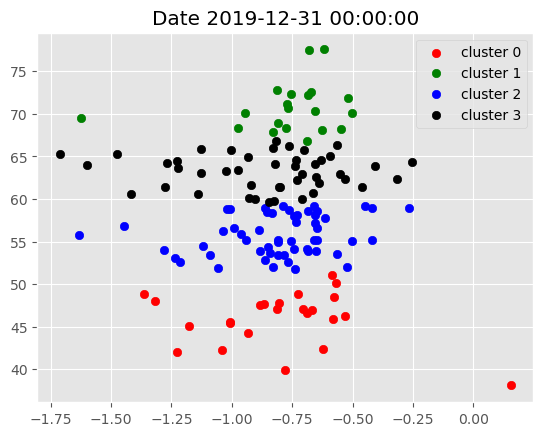

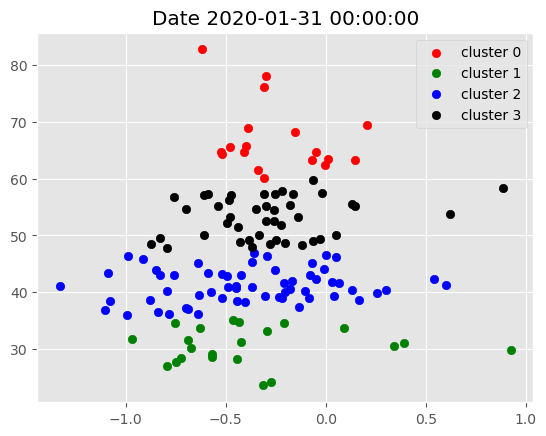

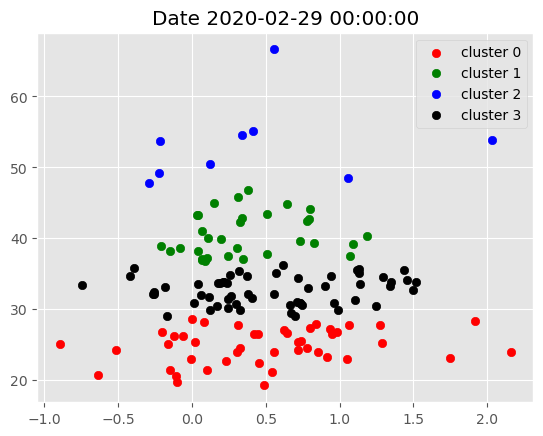

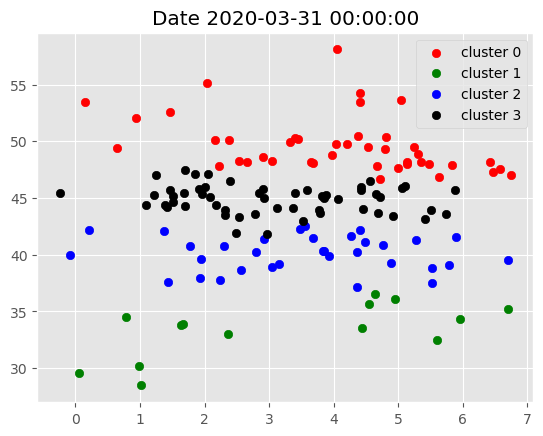

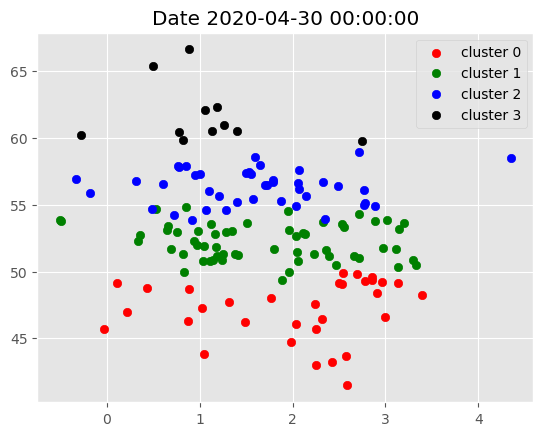

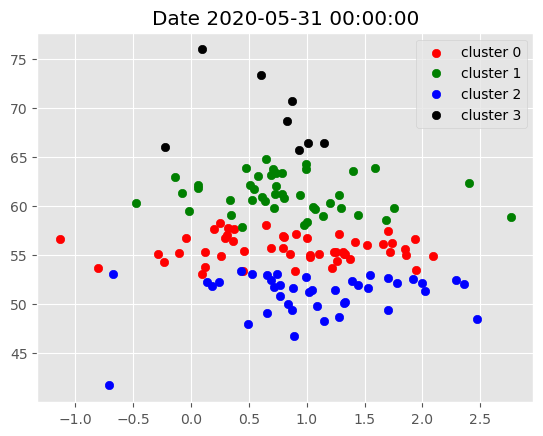

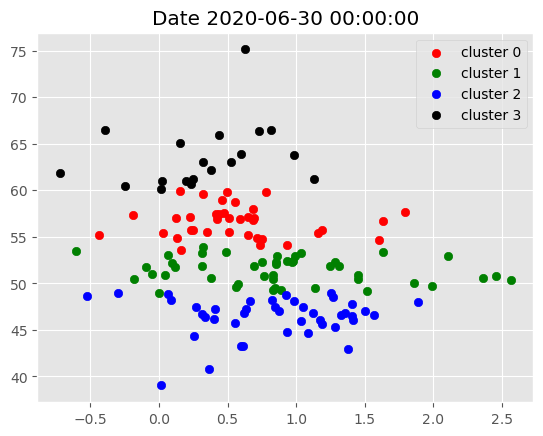

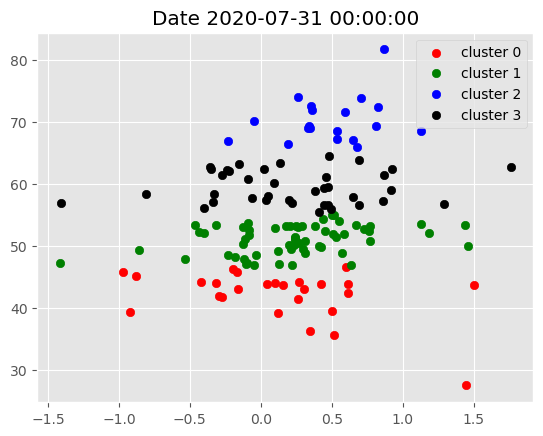

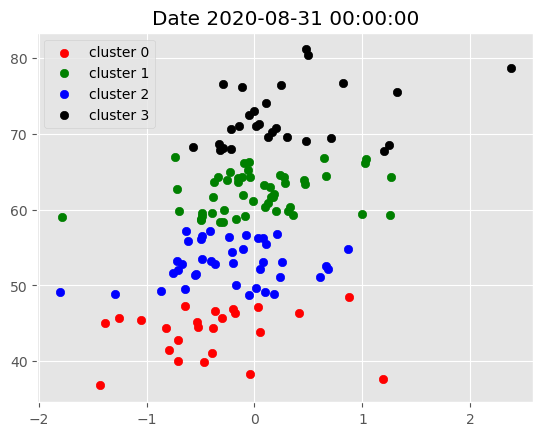

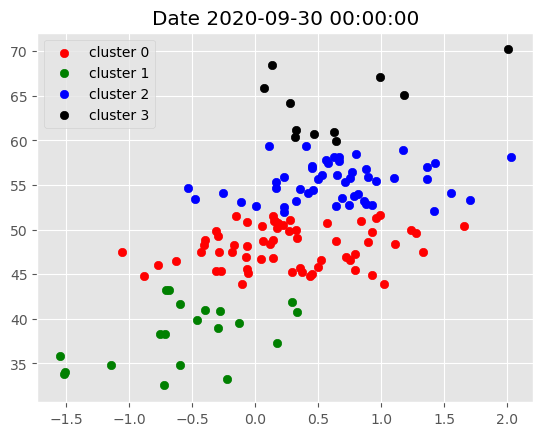

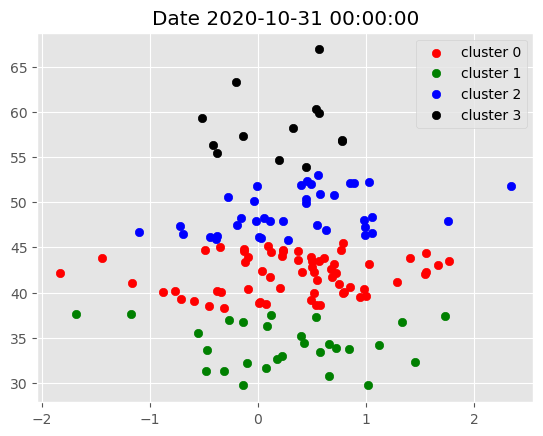

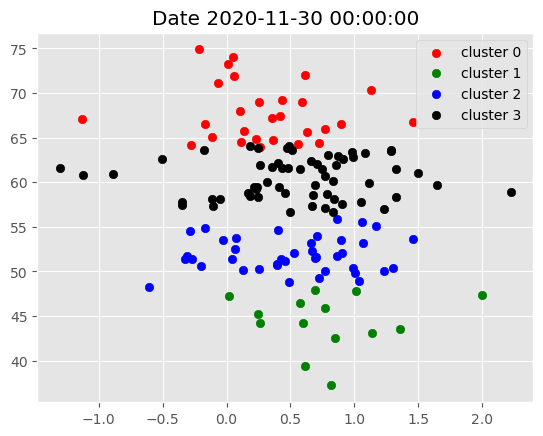

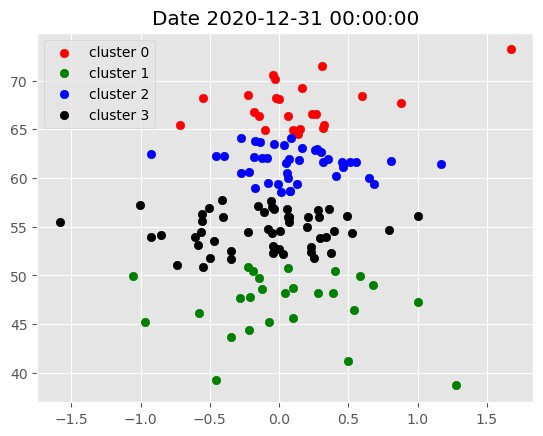

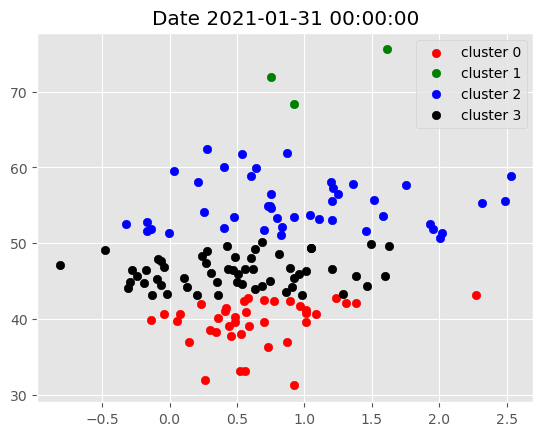

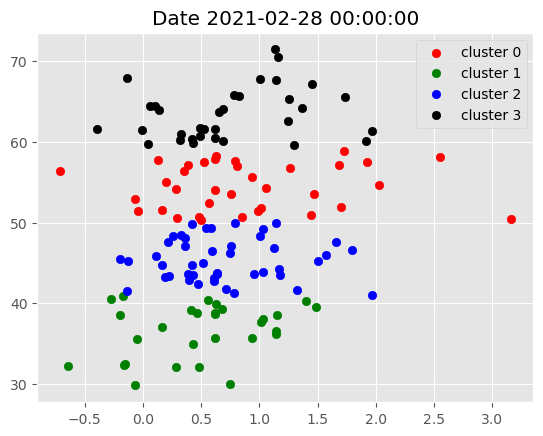

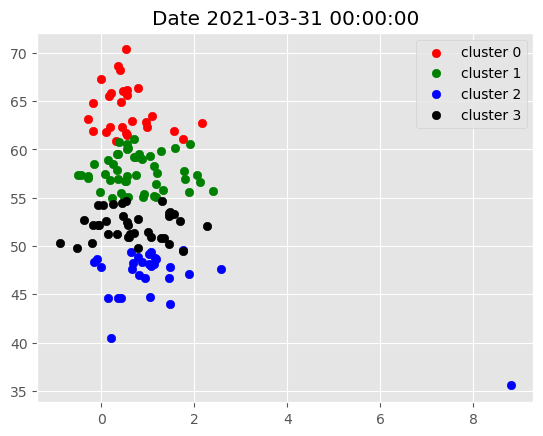

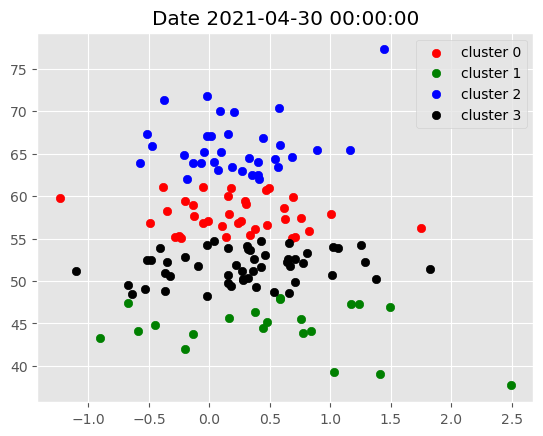

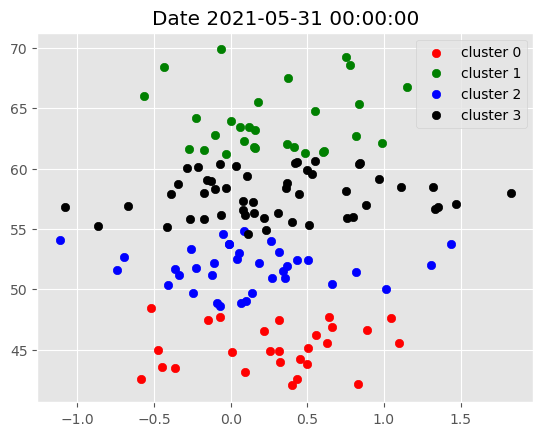

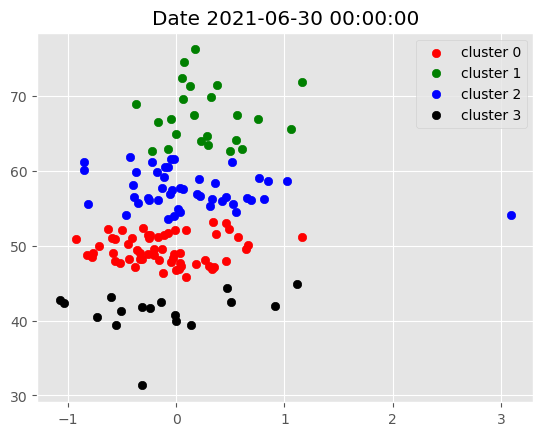

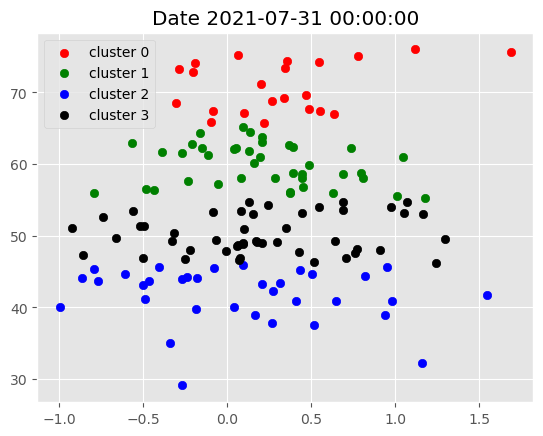

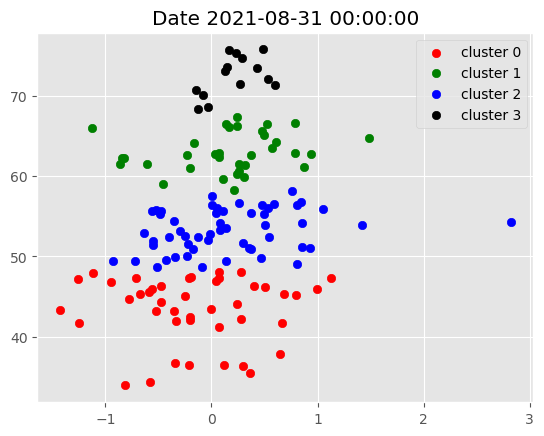

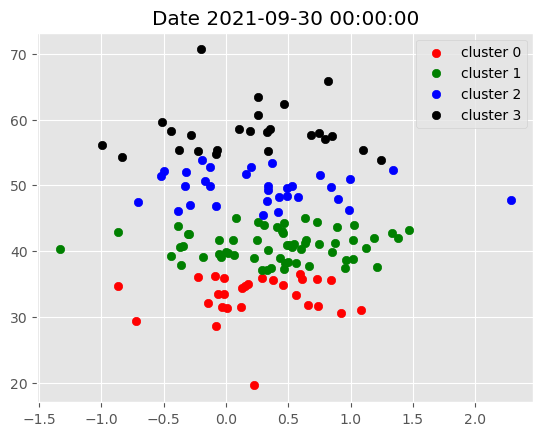

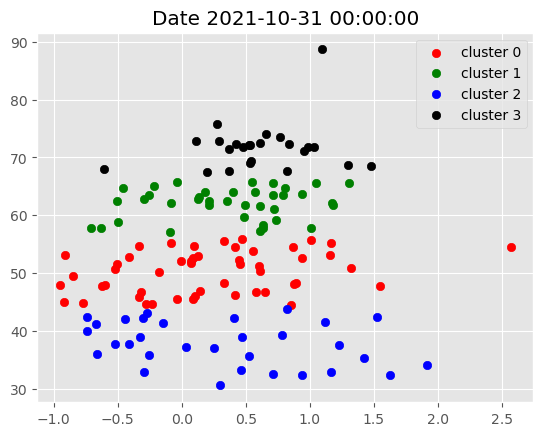

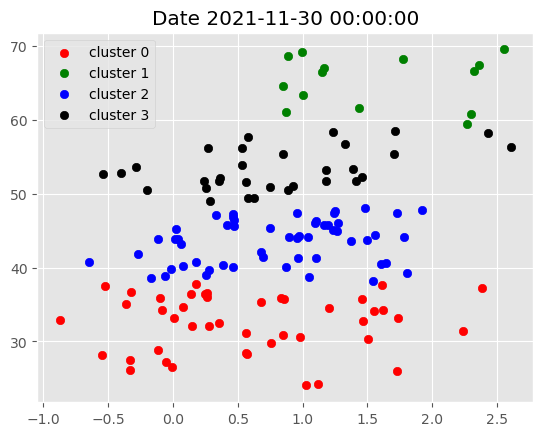

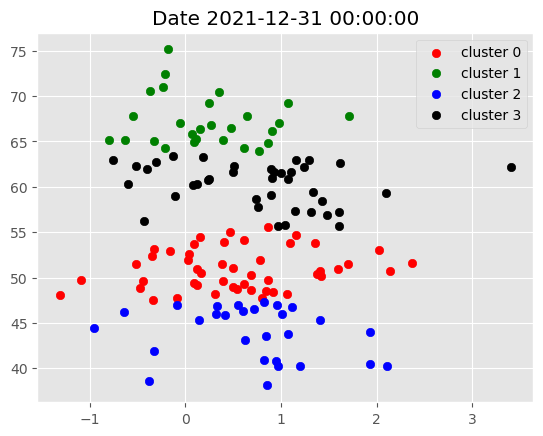

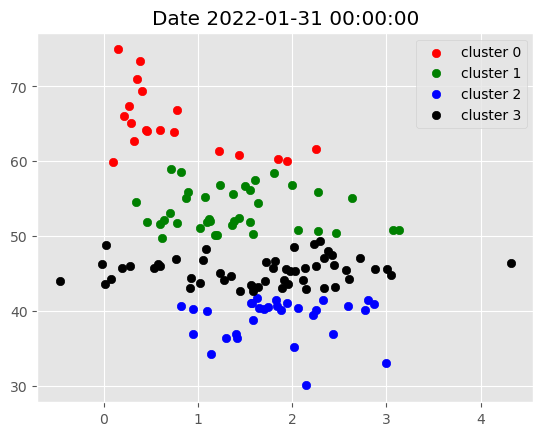

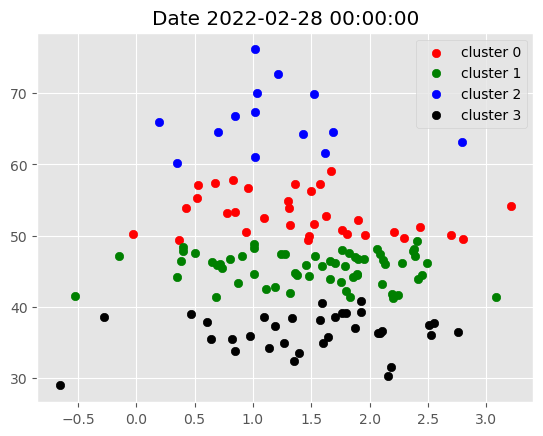

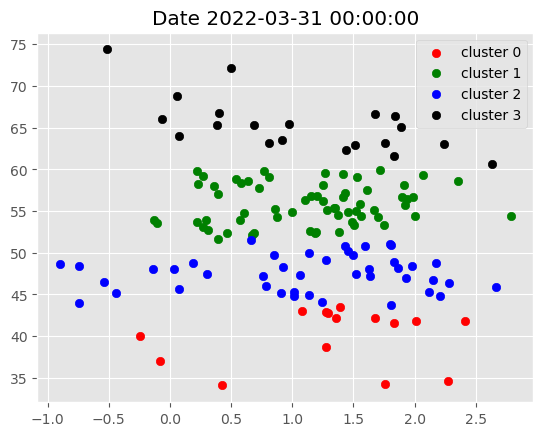

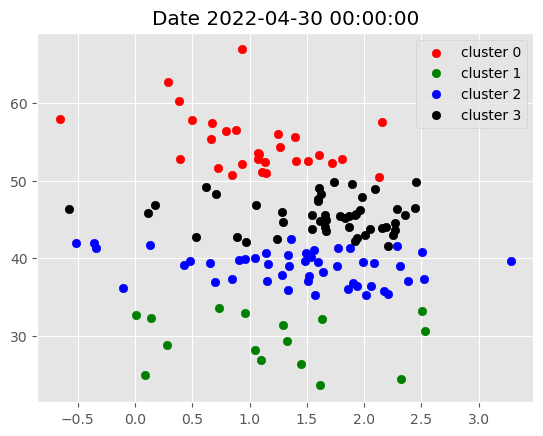

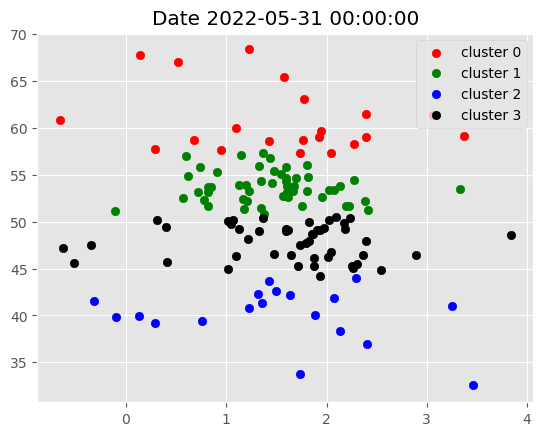

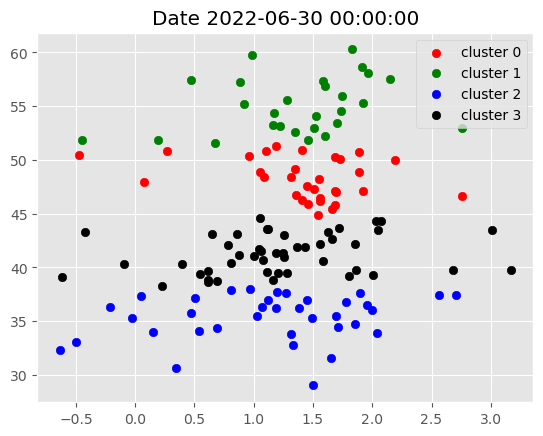

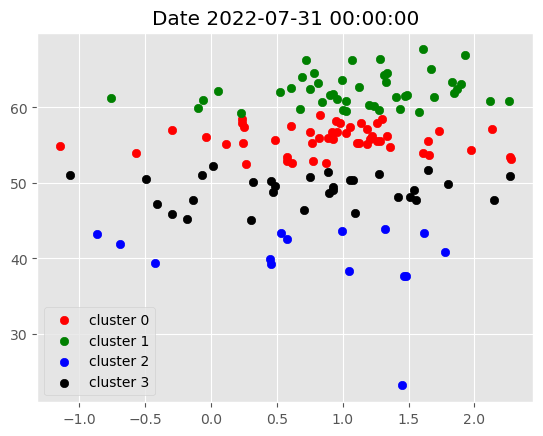

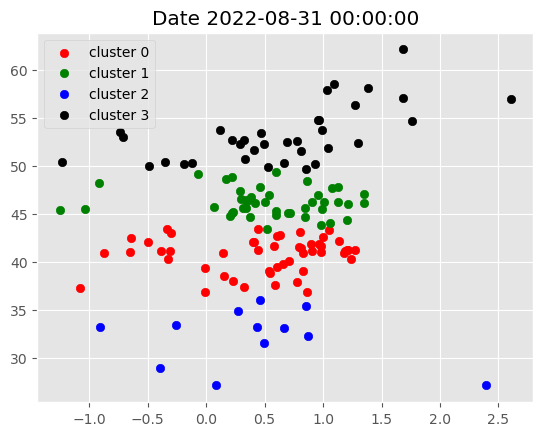

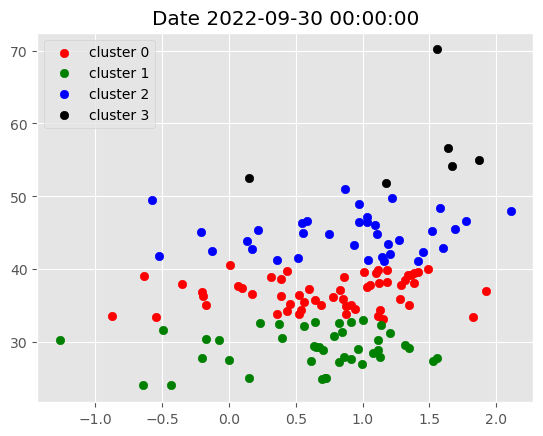

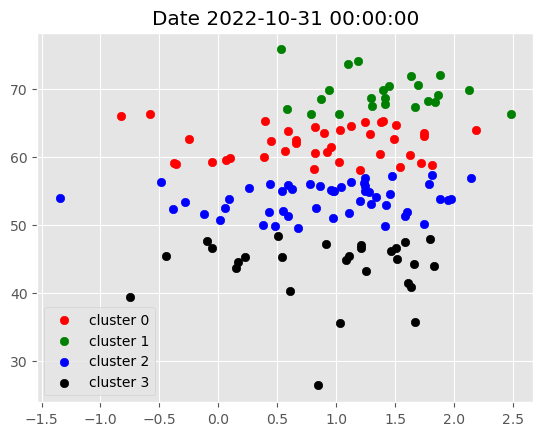

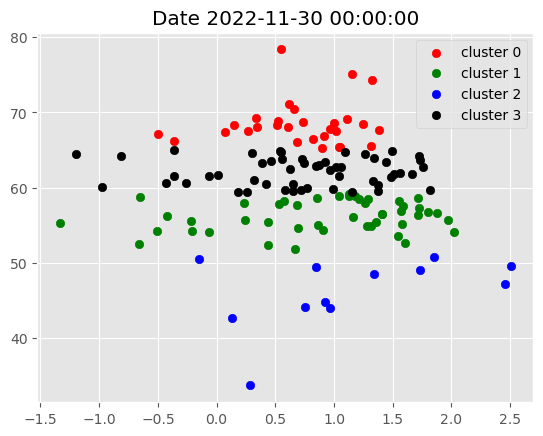

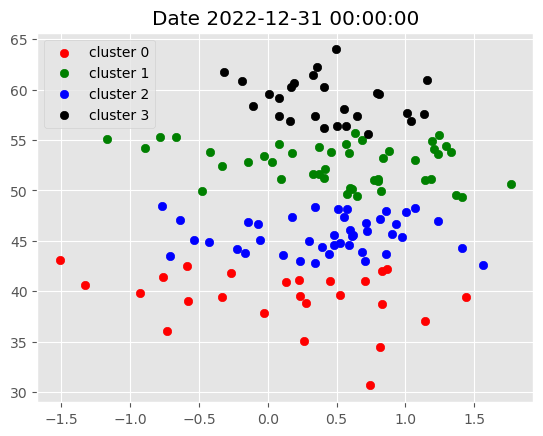

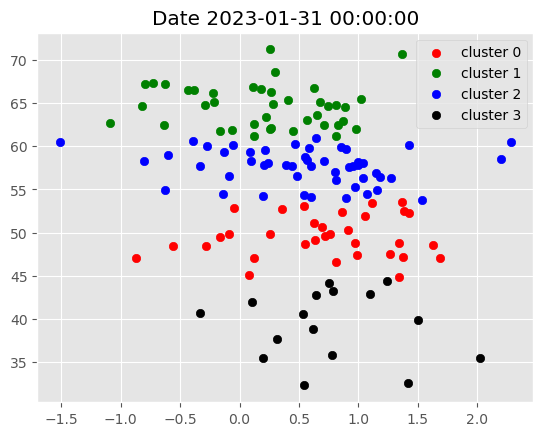

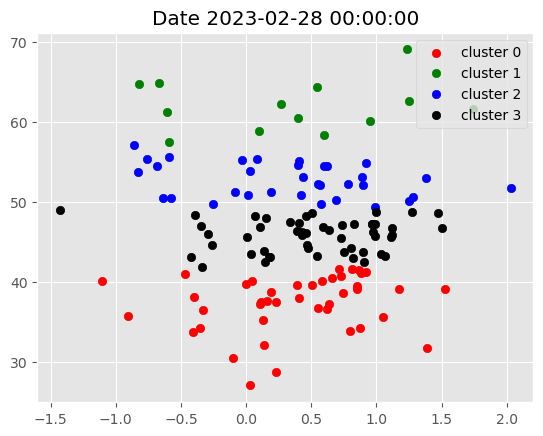

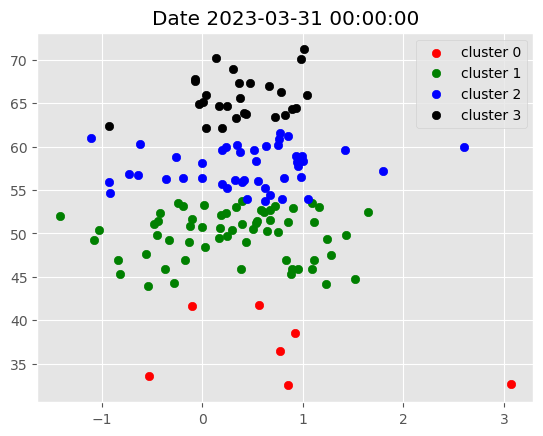

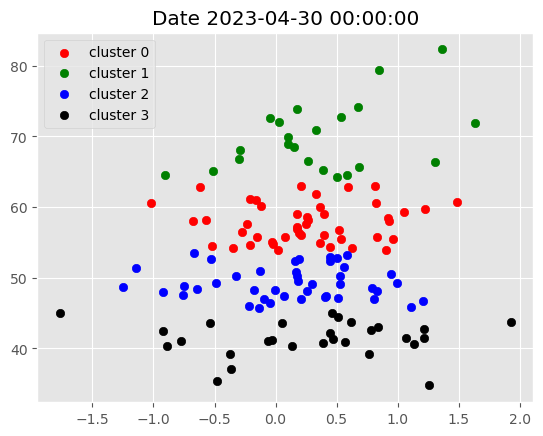

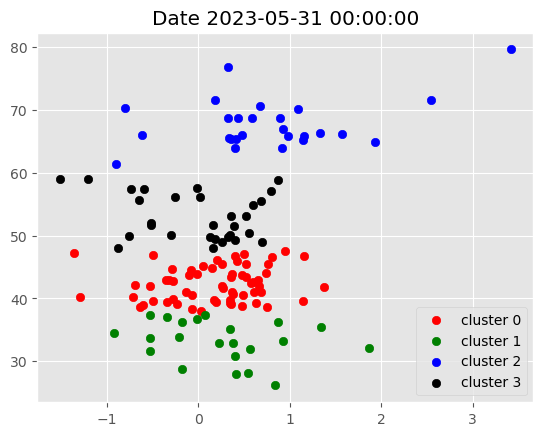

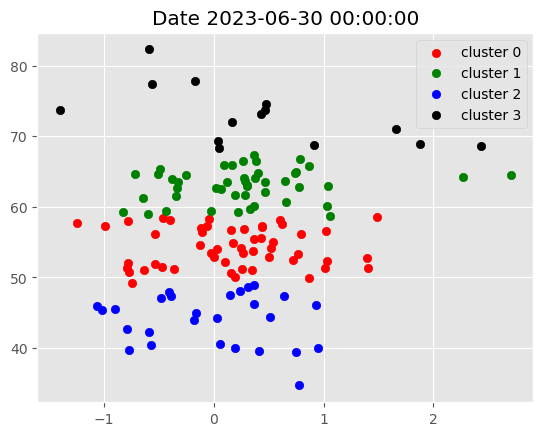

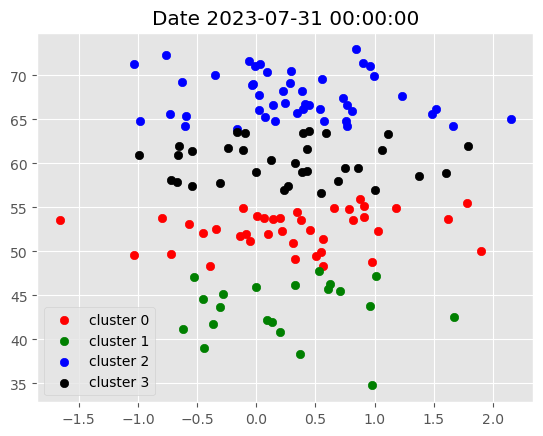

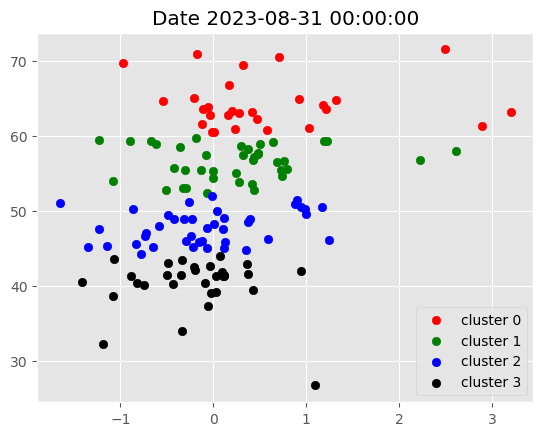

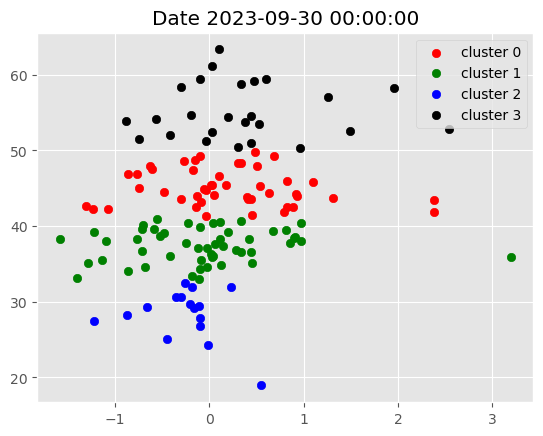

In [51]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [53]:
#I need to cluster stocks which are having high RSI (stocks having upward momentum) so that I can invest on it. Here we can see that the 
# top cluster is most of the times having 60+ RSI. 2 middles clusters ranging from 40 to 60. Lowest one around 30 or below
# cluster 0 is not always the top cluster, ie the cluster with having more RSI. So, we need to help K-Means by giving initial centroids

## Apply Pre-defined centroids


In [58]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [64]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001263  69.196721  3.590193  3.637059  3.683926   
           ABBV           -0.042702  55.247895  4.161565  4.207901  4.254238   
           ABT            -0.007128  53.844859  3.873128  3.896688  3.920248   
           ACN            -0.005423  69.365505  4.785195  4.824869  4.864543   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000186  54.722524  3.974950  3.992416  4.009883   
           XOM            -0.001011  59.440184  4.653137  4.693220  4.733304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276571 -0.251243   
           ABBV     0.056495   0.047273    0.044026  0.505457  0.360911   
           ABT      0.038672   0.031320    0.029294  0.833397 -0.194768   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154549   
           ADBE     0.045993   0.049515    0.041515  1.109844 -0.318351   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743557 -0.259226   
           XOM      0.012838   0.008747    0.027037  1.007000 -1.089040   
           MRNA    -0.071952  -0.064976   -0.015431  1.153082  0.830491   
           UBER     0.057244   0.066838    0.043691  1.089140  1.123820   
           CRWD     0.026391   0.047942   -0.002216  0.596069 -0.983458   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610483  0.680486  0.488789        3  
           ABBV   -0.030511  0.179041  0.188214        2  
           ABT    -0.528561  0.255634  0.985798        2  
           ACN    -0.339659  0.270195  0.196830        3  
           ADBE   -0.184551 -0.218162 -0.687480        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.508948 -0.128718  0.631455        2  
           XOM     1.679912 -0.722018 -0.271997        3  
           MRNA   -1.184026  0.623413  1.031253        1  
           UBER   -0.230611 -1.531531 -0.492785        1  
           CRWD   -0.701906 -2.504523 -0.806878        2  

[10126 rows x 19 columns]

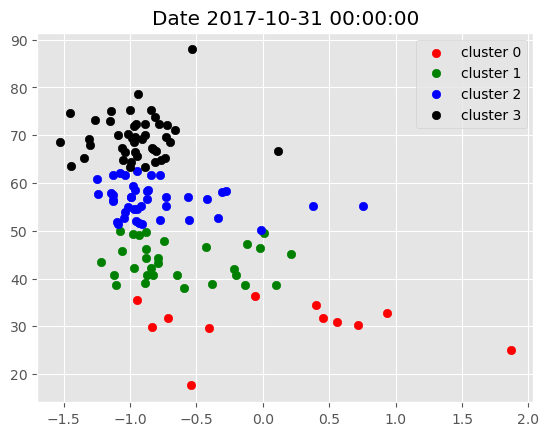

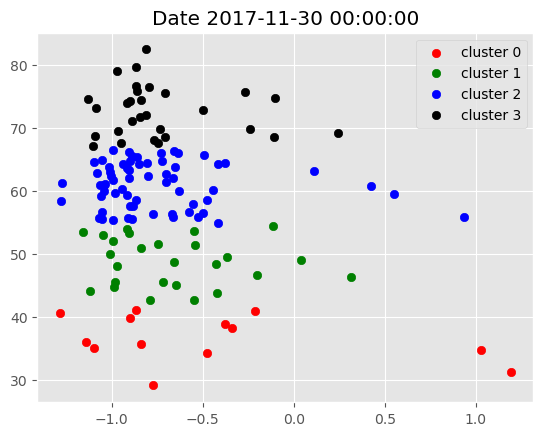

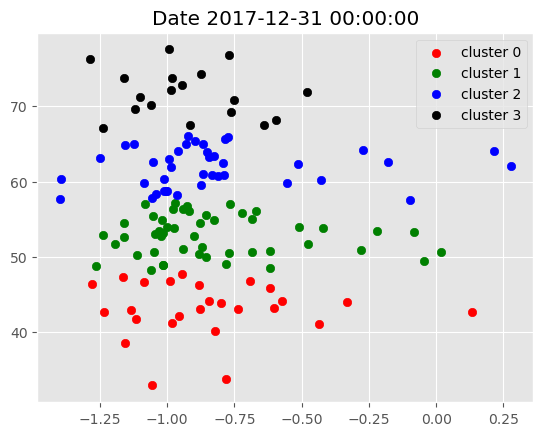

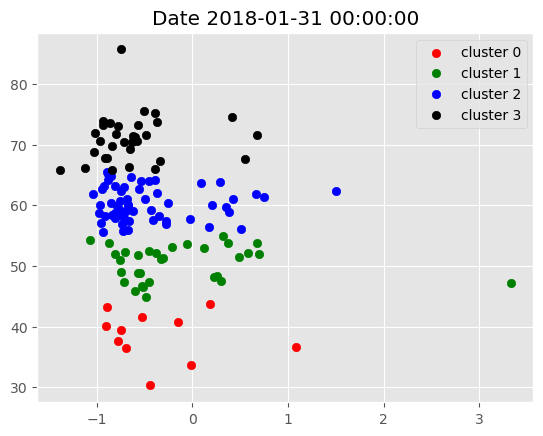

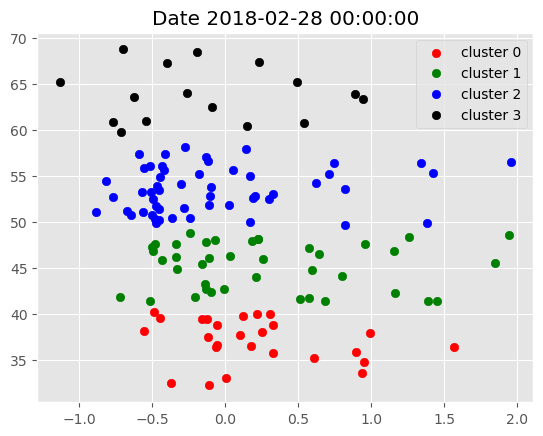

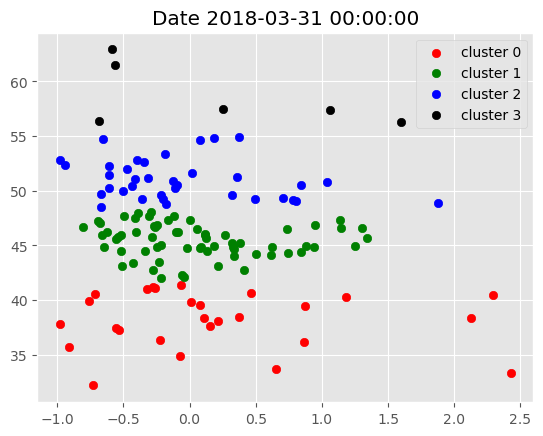

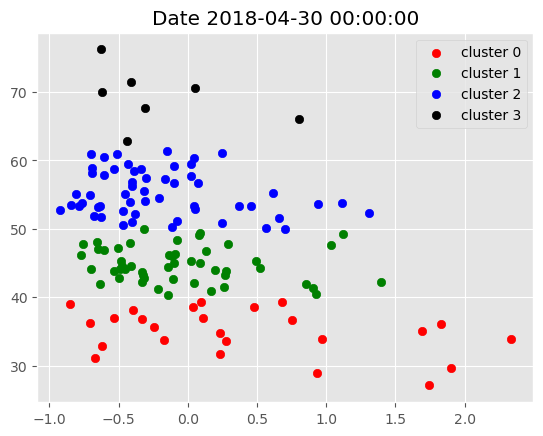

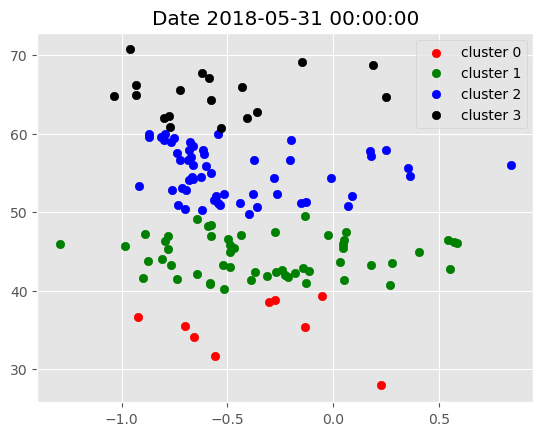

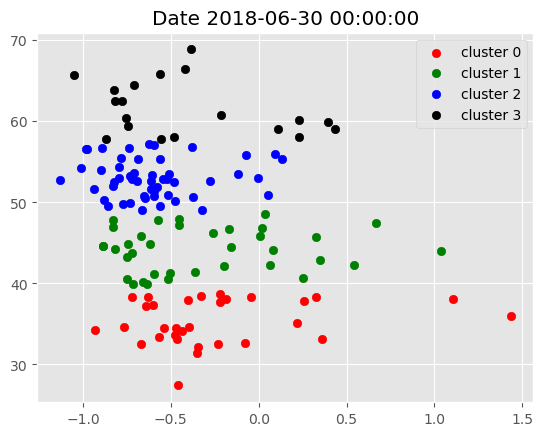

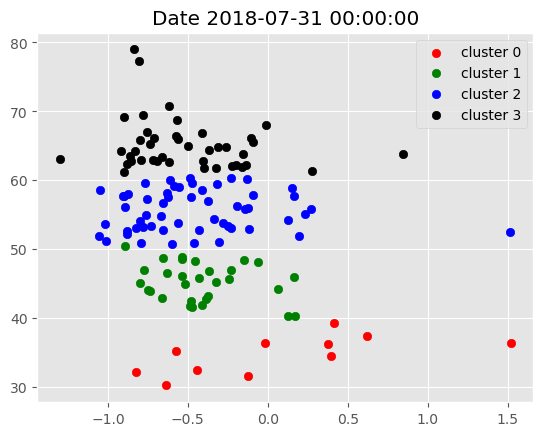

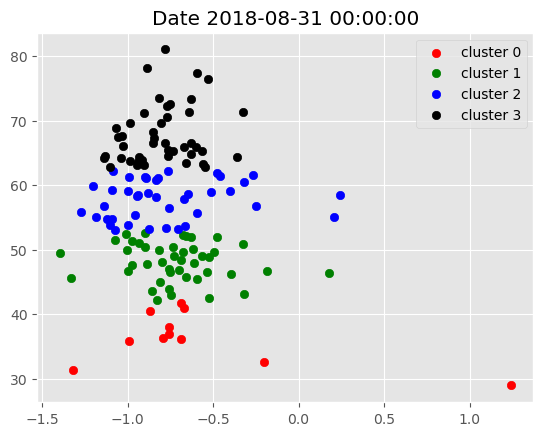

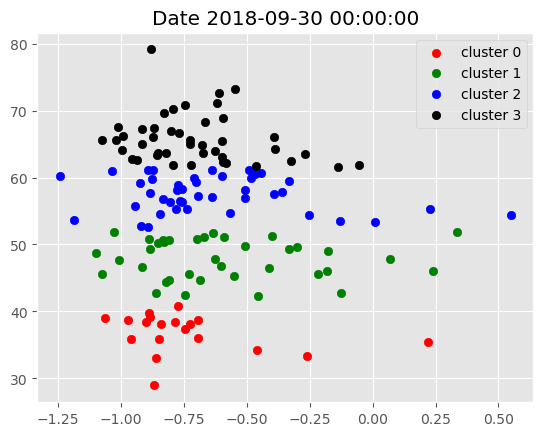

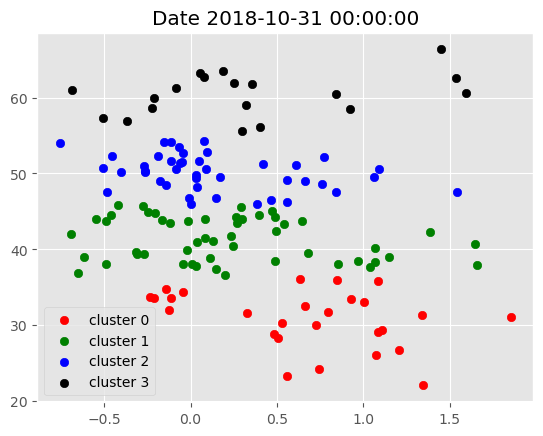

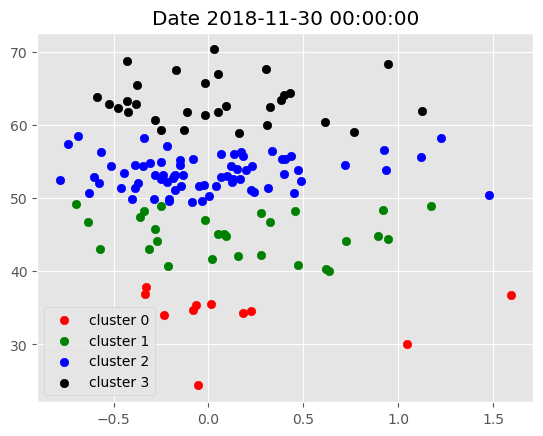

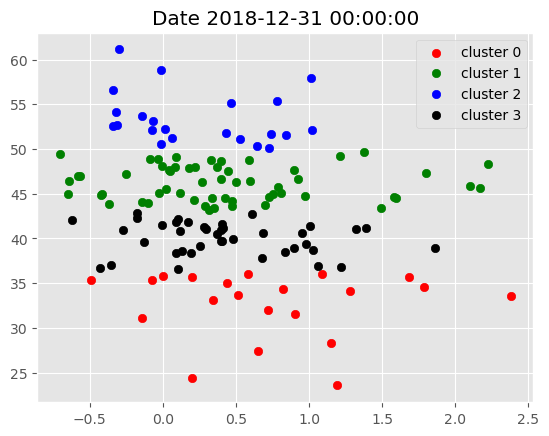

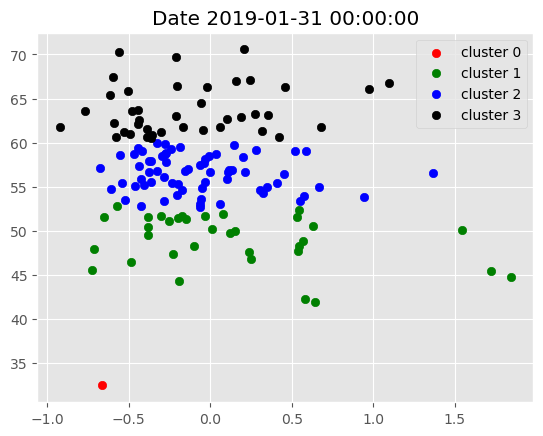

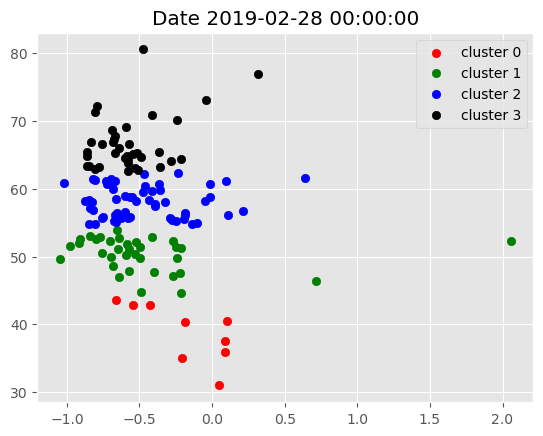

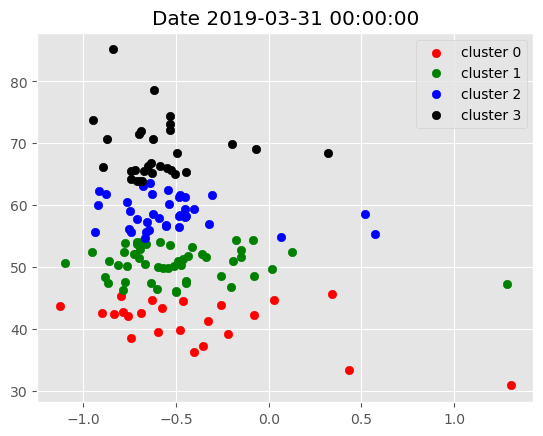

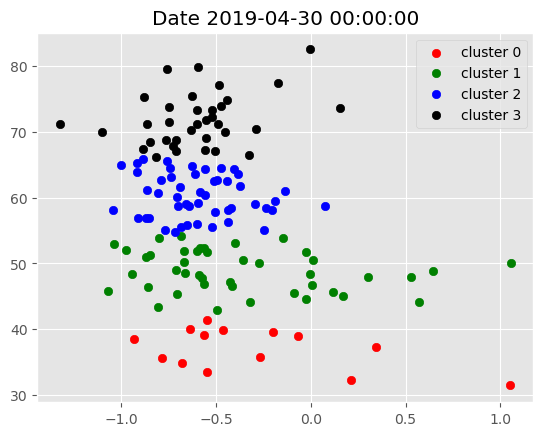

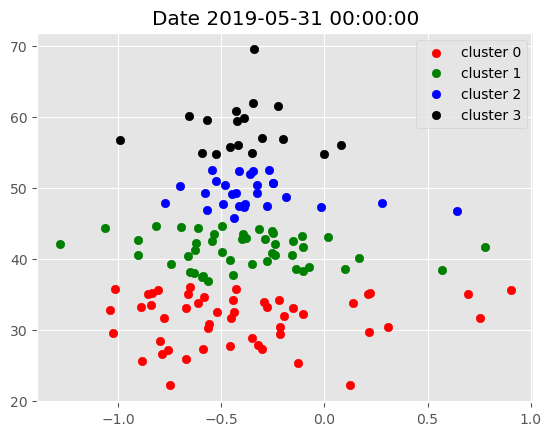

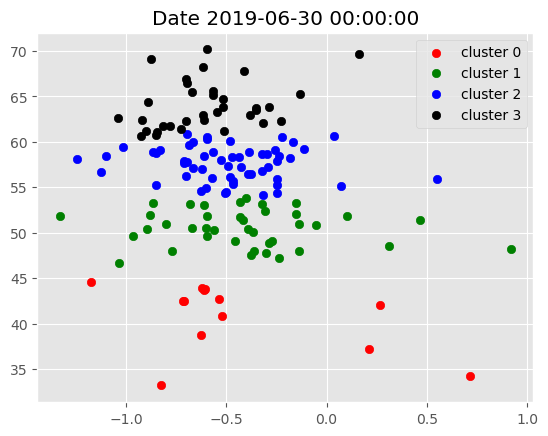

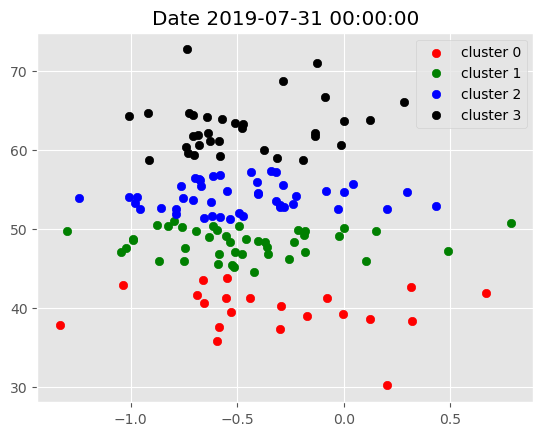

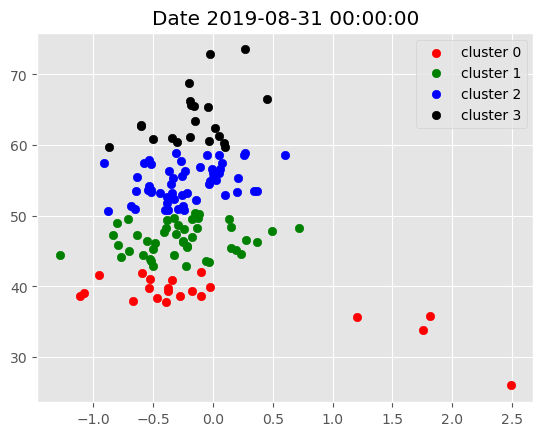

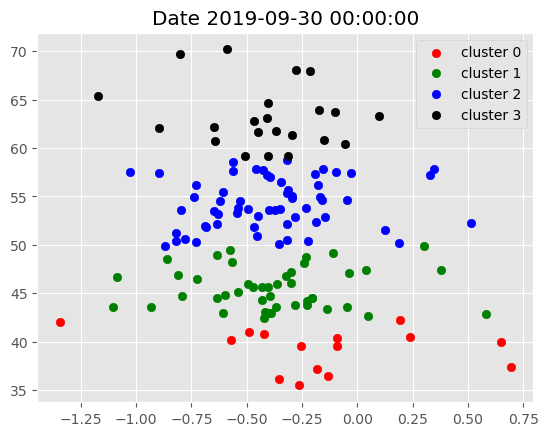

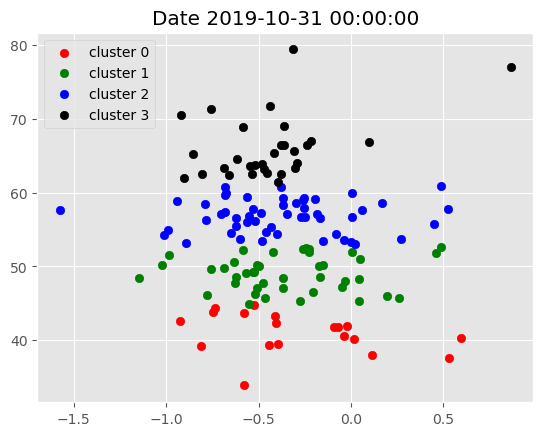

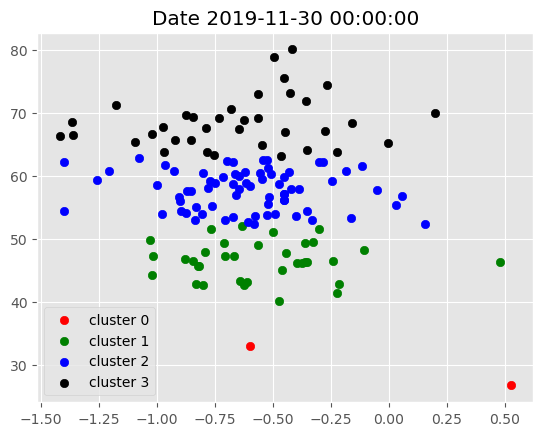

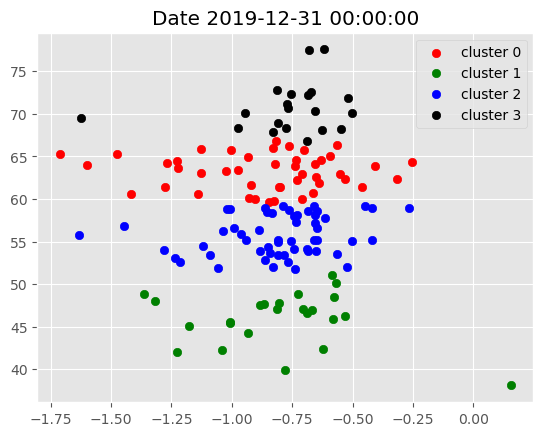

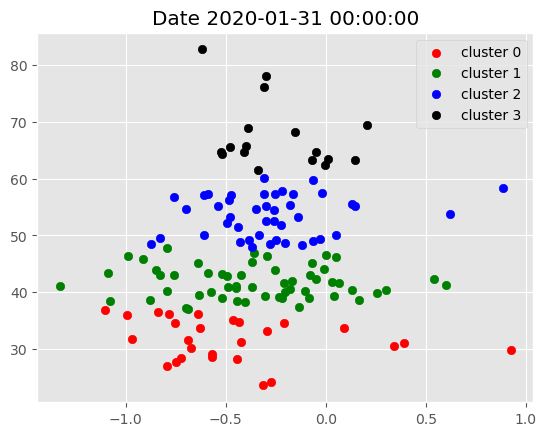

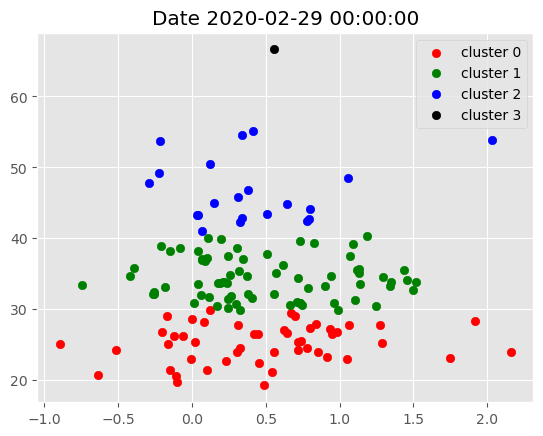

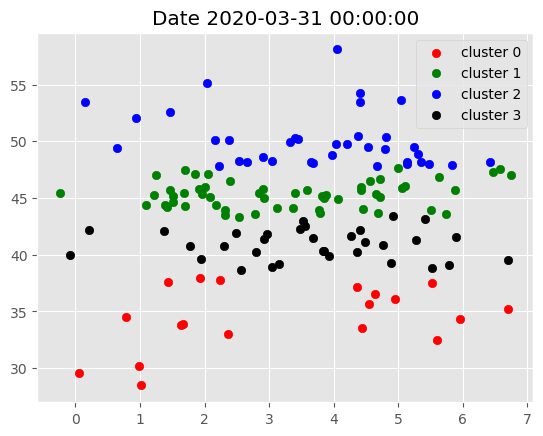

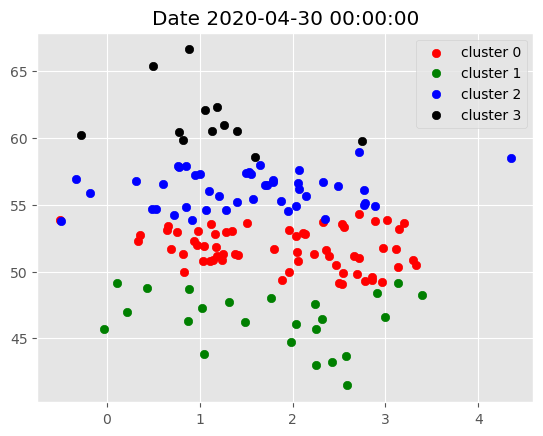

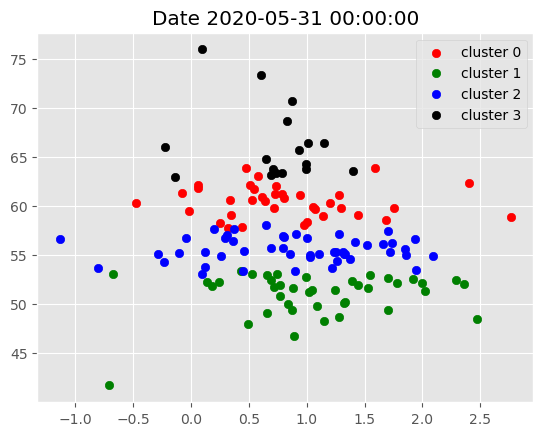

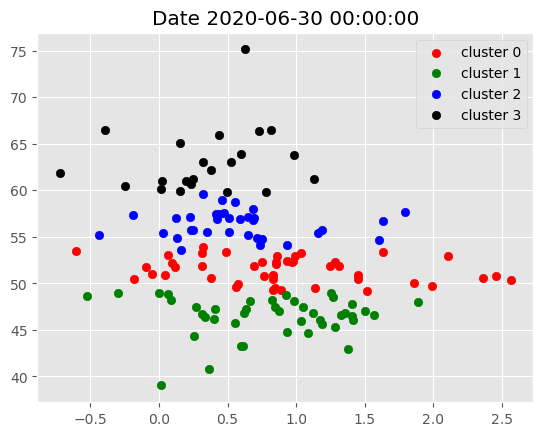

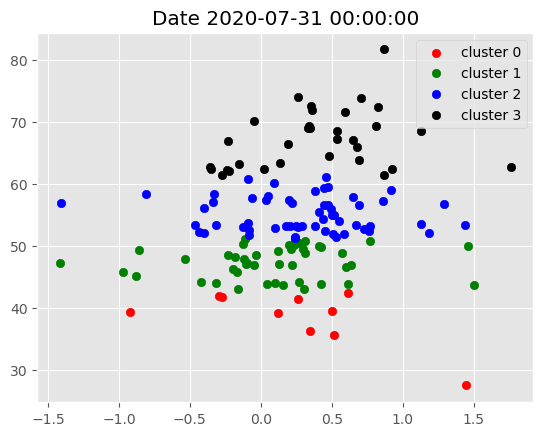

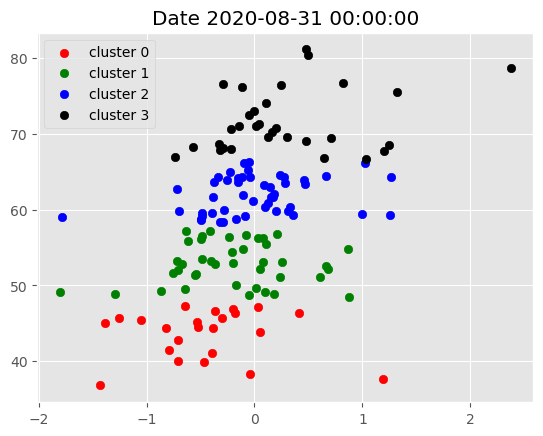

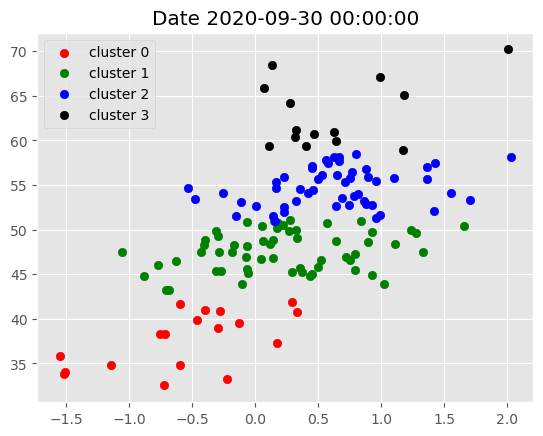

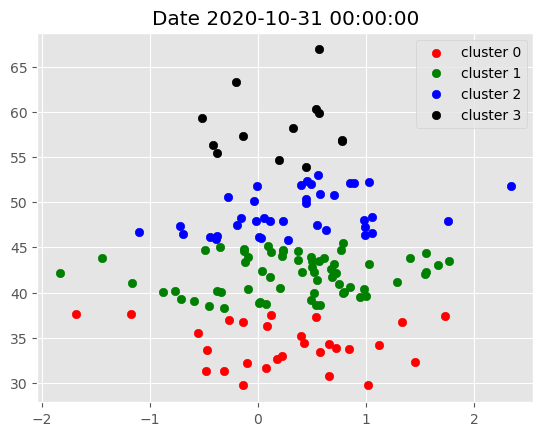

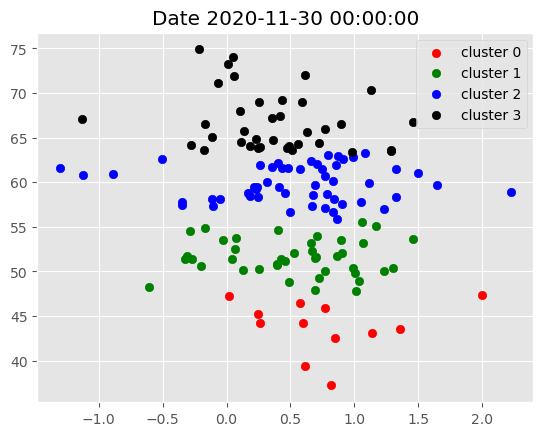

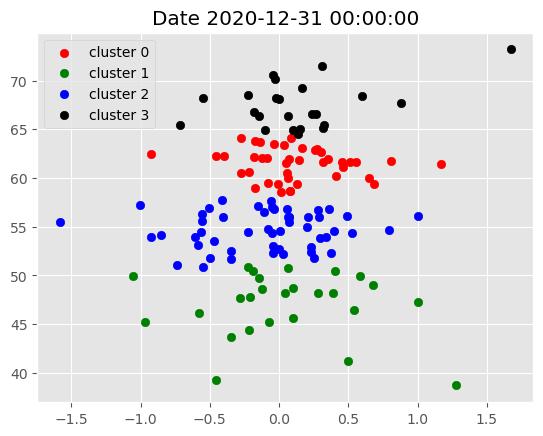

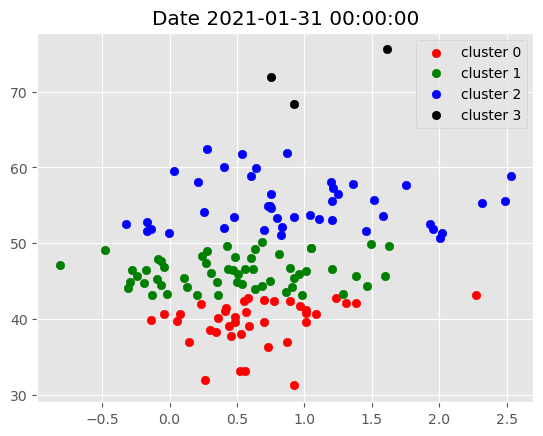

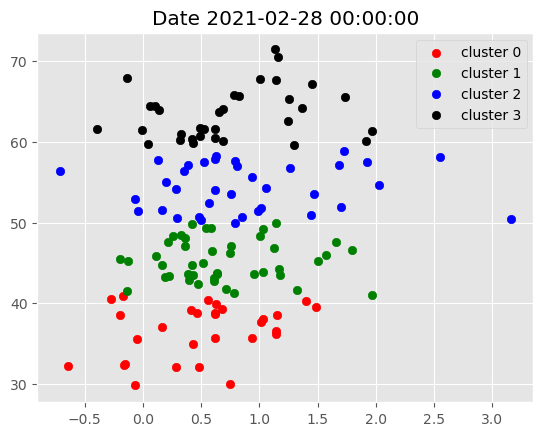

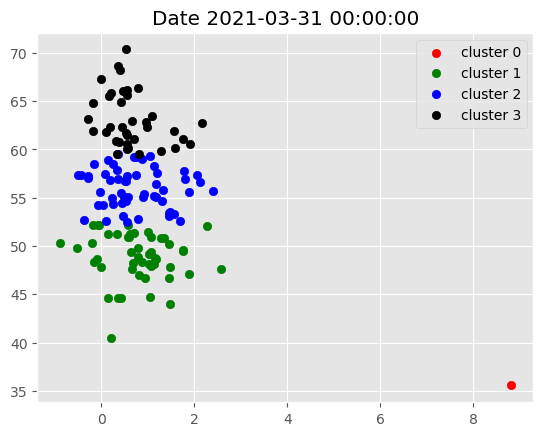

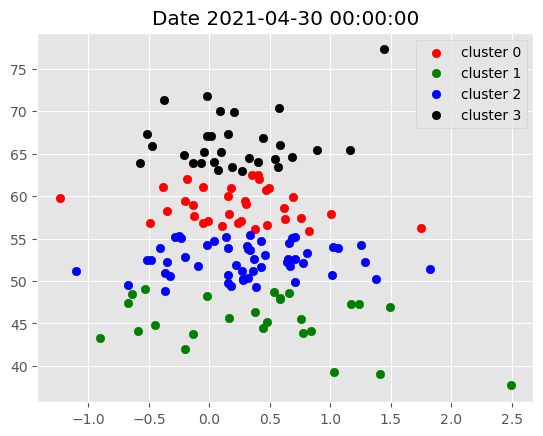

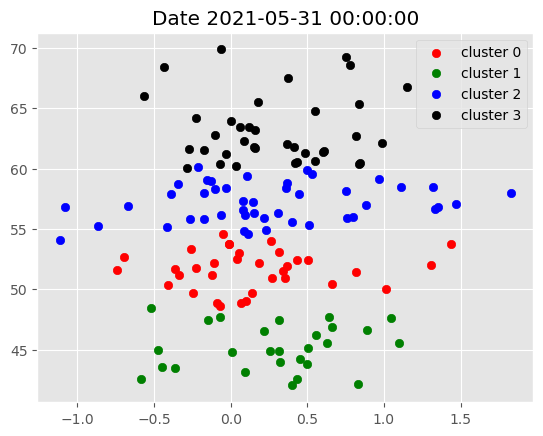

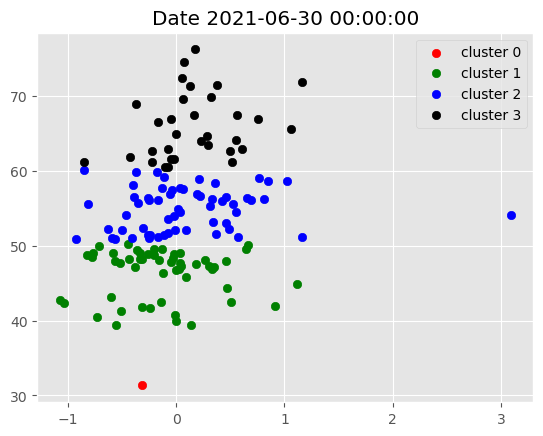

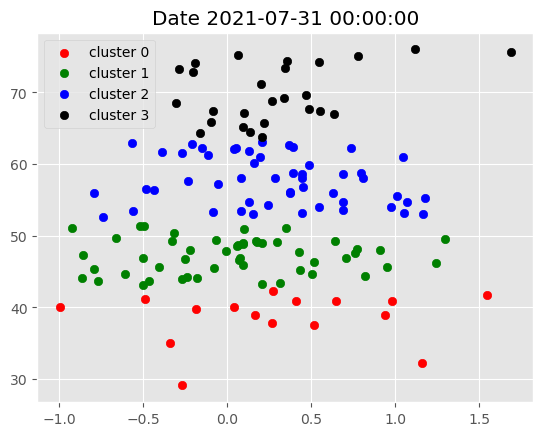

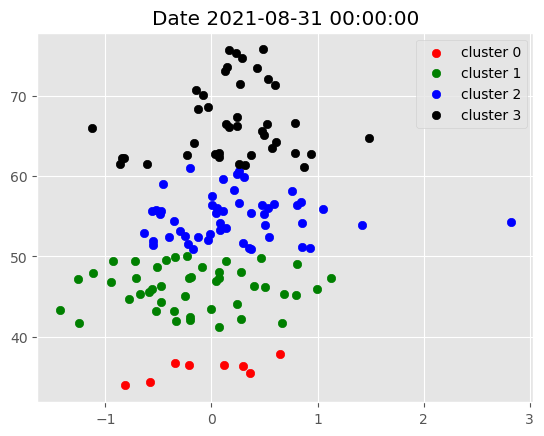

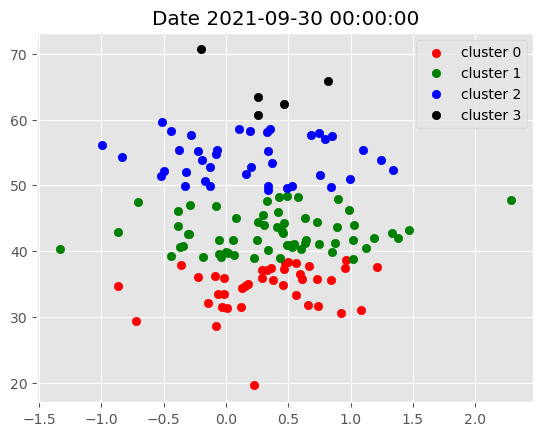

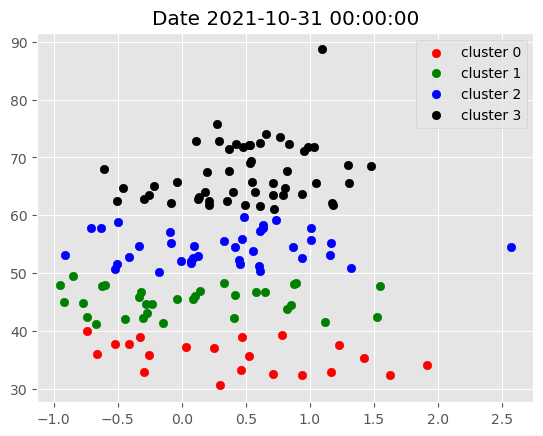

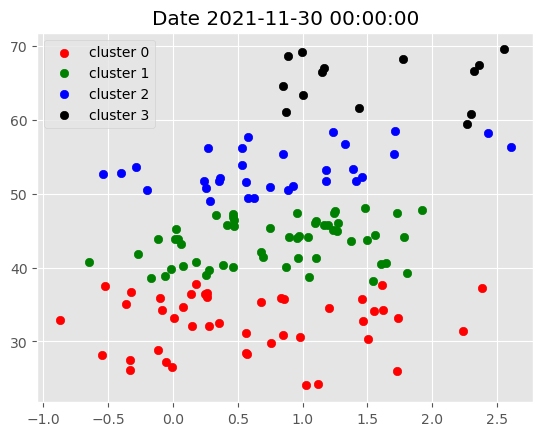

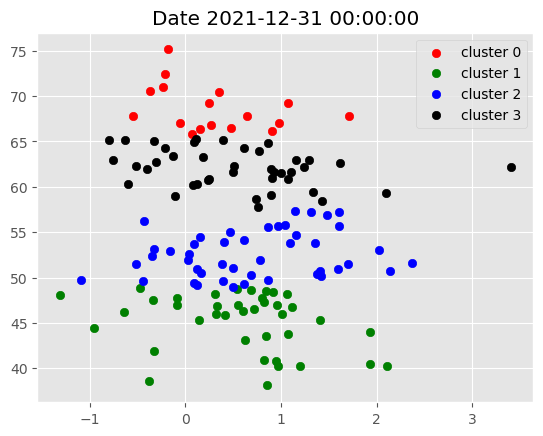

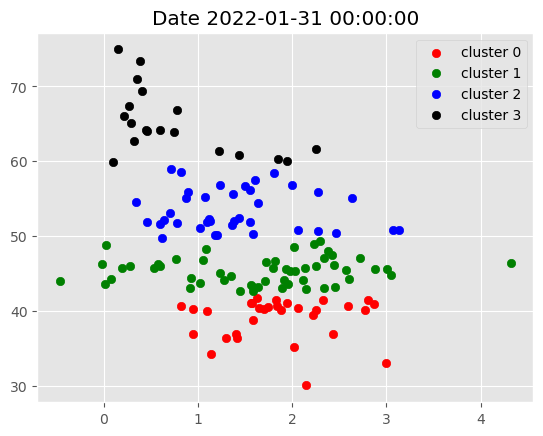

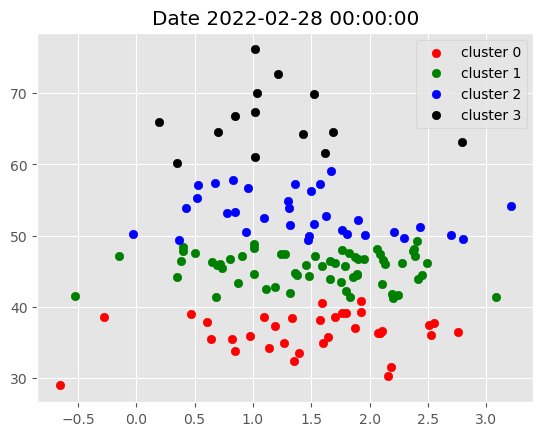

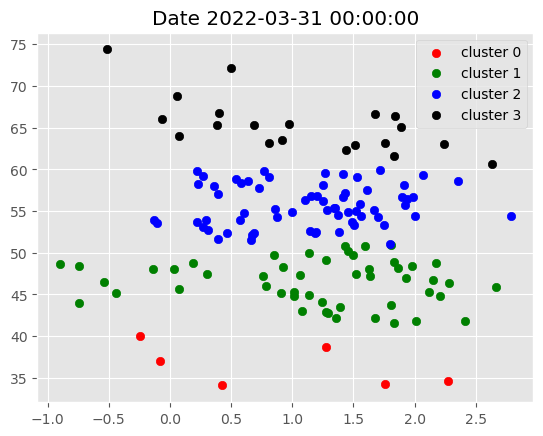

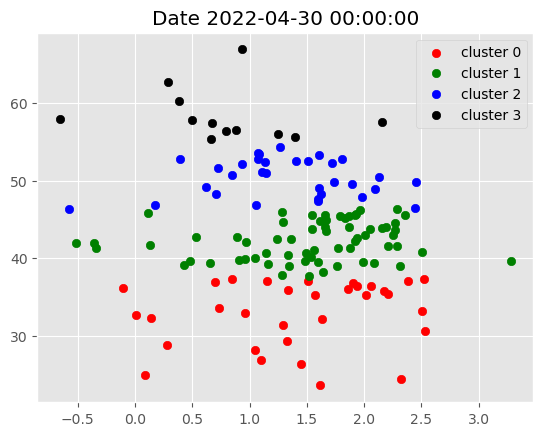

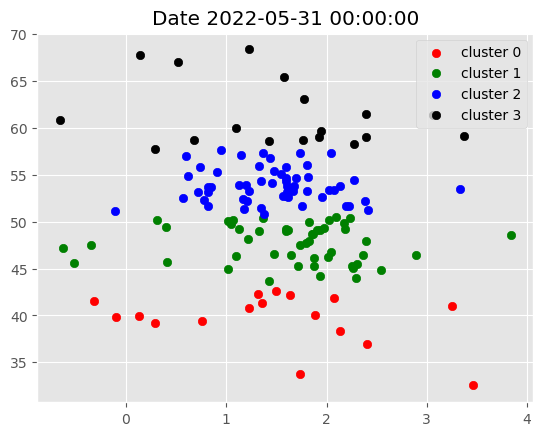

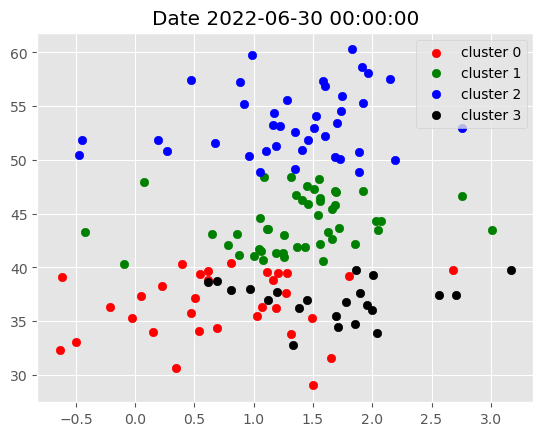

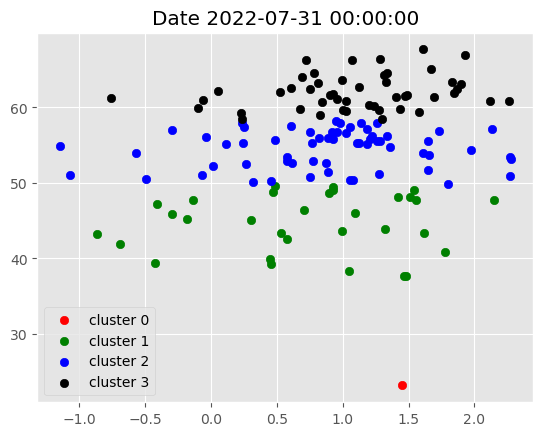

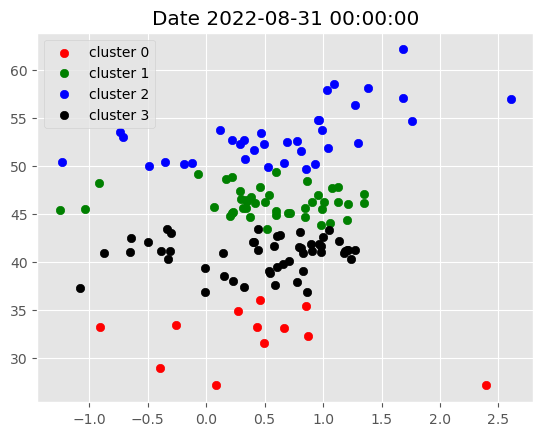

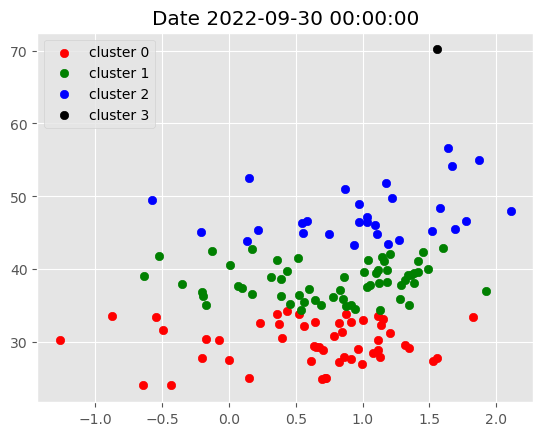

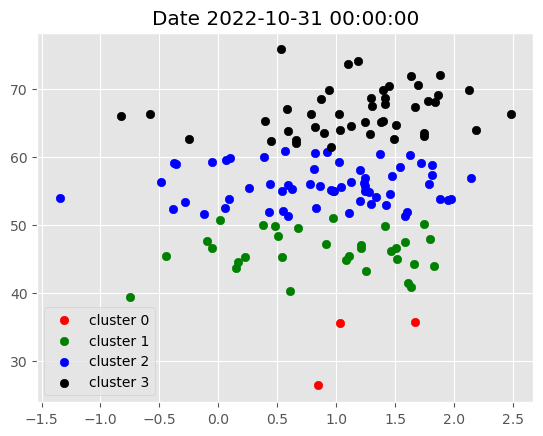

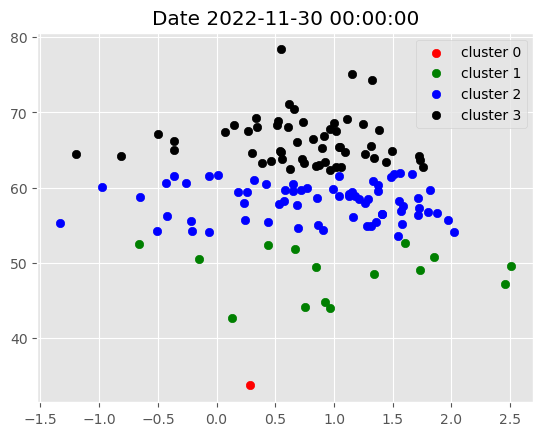

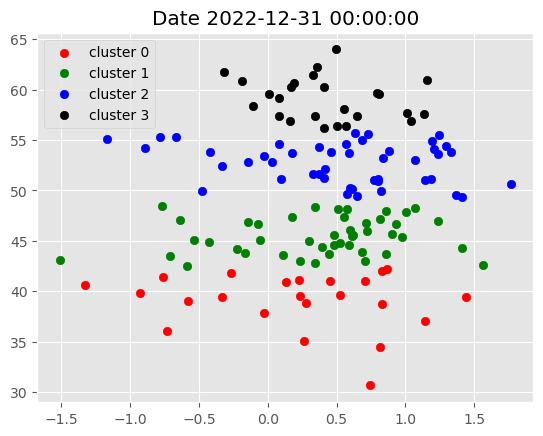

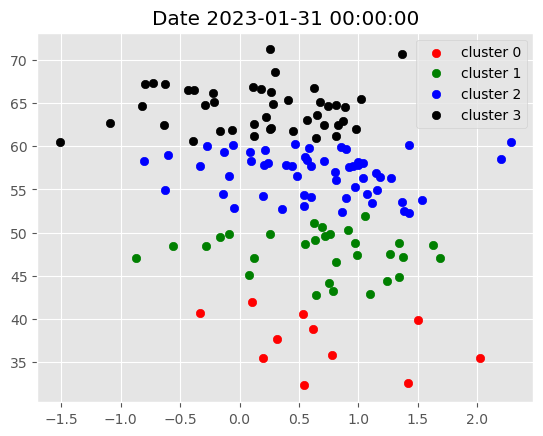

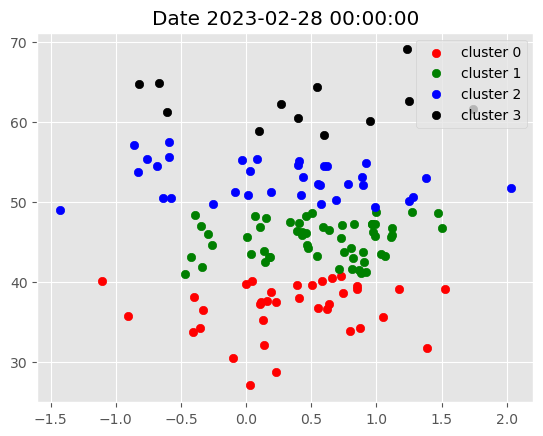

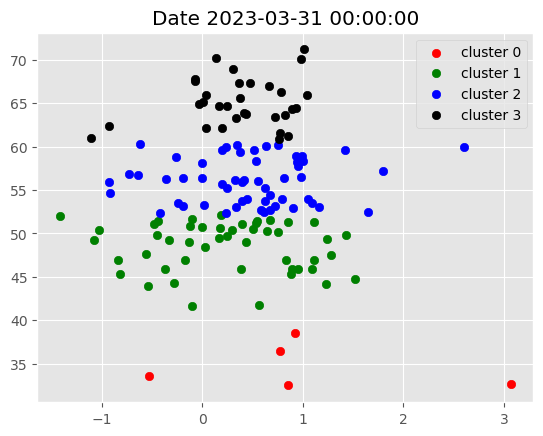

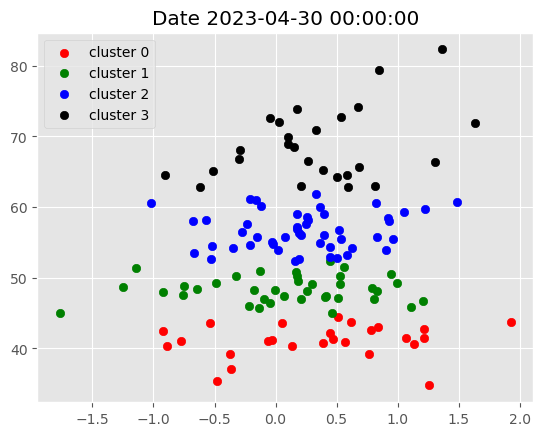

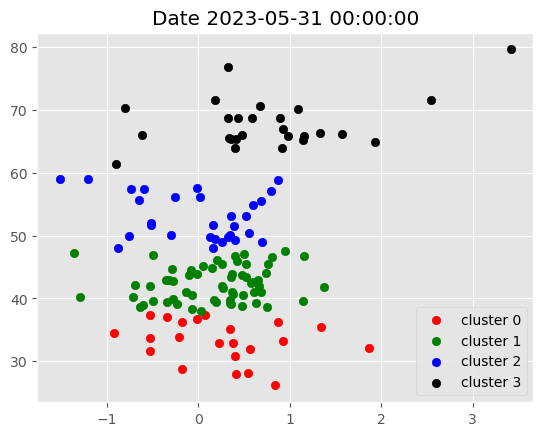

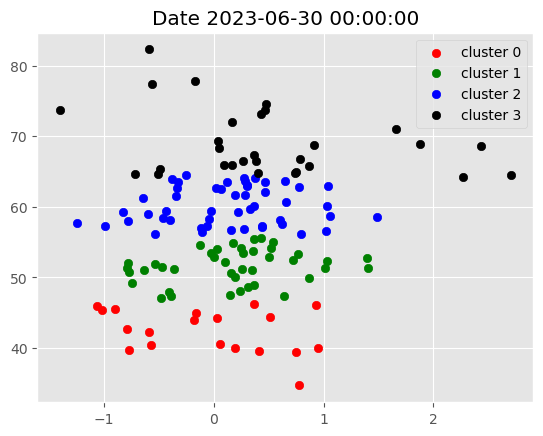

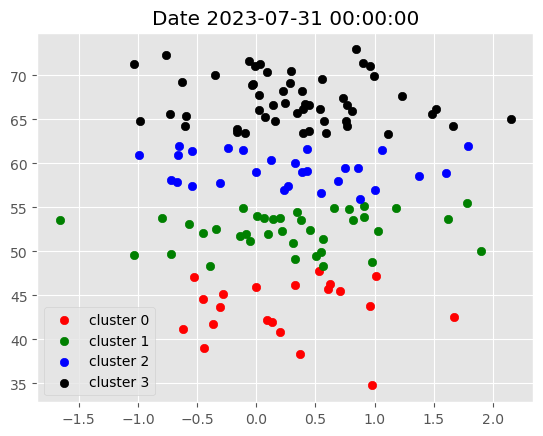

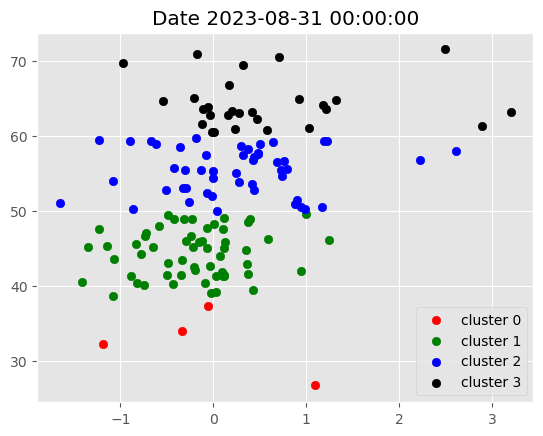

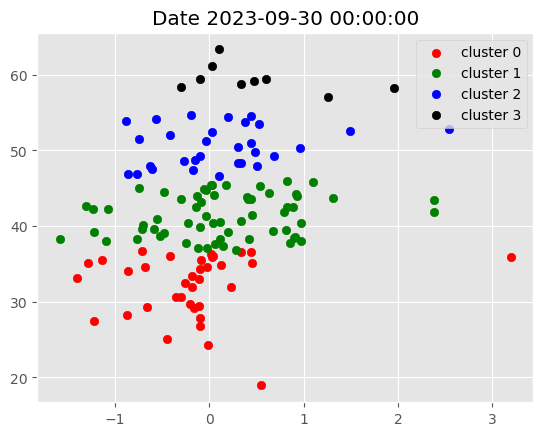

In [66]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [68]:
# Now we can say that stocks in cluster 3 have good upward momentum

## Portfolio Construction Using Cluster-Based Selection and Efficient Frontier Optimization

We begin by selecting stocks each month based on their assigned cluster, guided by a hypothesis-driven approach.

In this case, the strategy focuses on momentum. The assumption is that momentum tends to persist, so stocks belonging to the cluster centered around high RSI values (e.g., near 70) are expected to continue outperforming in the following month. Based on this hypothesis, we specifically select stocks from Cluster 3, which exhibits these characteristics.

The selected stocks are then used to construct a portfolio, optimized monthly using the Efficient Frontier method to maximize the Sharpe ratio.

In [77]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001263  69.196721  3.590193  3.637059  3.683926   
           ABBV           -0.042702  55.247895  4.161565  4.207901  4.254238   
           ABT            -0.007128  53.844859  3.873128  3.896688  3.920248   
           ACN            -0.005423  69.365505  4.785195  4.824869  4.864543   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000186  54.722524  3.974950  3.992416  4.009883   
           XOM            -0.001011  59.440184  4.653137  4.693220  4.733304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276571 -0.251243   
           ABBV     0.056495   0.047273    0.044026  0.505457  0.360911   
           ABT      0.038672   0.031320    0.029294  0.833397 -0.194768   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154549   
           ADBE     0.045993   0.049515    0.041515  1.109844 -0.318351   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743557 -0.259226   
           XOM      0.012838   0.008747    0.027037  1.007000 -1.089040   
           MRNA    -0.071952  -0.064976   -0.015431  1.153082  0.830491   
           UBER     0.057244   0.066838    0.043691  1.089140  1.123820   
           CRWD     0.026391   0.047942   -0.002216  0.596069 -0.983458   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610483  0.680486  0.488789        3  
           ABBV   -0.030511  0.179041  0.188214        2  
           ABT    -0.528561  0.255634  0.985798        2  
           ACN    -0.339659  0.270195  0.196830        3  
           ADBE   -0.184551 -0.218162 -0.687480        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.508948 -0.128718  0.631455        2  
           XOM     1.679912 -0.722018 -0.271997        3  
           MRNA   -1.184026  0.623413  1.031253        1  
           UBER   -0.230611 -1.531531 -0.492785        1  
           CRWD   -0.701906 -2.504523 -0.806878        2  

[10126 rows x 19 columns]

In [79]:
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

In [83]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD'

## Define Portfolio Optimization Function

We define a function to optimize portfolio weights using the Efficient Frontier from the PyPortfolioOpt library, with the objective of maximizing the Sharpe ratio.

To perform this optimization, the function requires daily prices from the past one year for the selected stocks. This historical data is used to estimate expected returns and the covariance matrix.

To encourage diversification and prevent overconcentration, we impose weight constraints on individual stocks:
	•	Minimum weight: 50% of equal weight
	•	Maximum weight: 10% of the portfolio

In [92]:
#What is the goal of the optimization?

#Find the best set of weights for the selected stocks that gives the highest Sharpe ratio, i.e., the most efficient return per unit of risk

#This is known as the maximum Sharpe ratio portfolio — a classic portfolio theory concept.

⚖️ Why impose weight constraints?

If you don’t, the optimizer might:

	•	Put 90% of your money in 1 stock that looks the best
 
	•	Or completely ignore some stocks

To fix that, you add diversification constraints:

	•	Equal weight = 1 / N (if N = 10, equal weight = 0.10)
 
	•	You set:
 
	•	Minimum weight = 50% of that → 0.05
 
	•	Maximum weight = 0.10

So:
	•	🔒 No stock can be more than 10% of your portfolio
 
	•	✅ Every stock must be at least 5% (if selected)

This makes your portfolio balanced and more robust.

In [95]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [146]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

adj_close_df = new_df['Adj Close'].copy()
adj_close_df.columns.name = None  # remove the level name

[*********************100%***********************]  156 of 156 completed


	•	Calculate daily returns for all stocks that are potential candidates for inclusion in the portfolio.
	•	For each month’s start date:
	•	Select the corresponding set of stocks based on the cluster assignment.
	•	Use the most recent 1-year daily price data to estimate expected returns and risk.
	•	Apply Efficient Frontier optimization to compute portfolio weights that maximize the Sharpe ratio.
	•	If the Sharpe ratio optimization fails or is not feasible for a given month (e.g., due to missing data or numerical issues), assign equal weights to the selected stocks as a fallback.
	•	Use the calculated weights to compute the daily portfolio return for the following month.

In [159]:
returns_dataframe = np.log(adj_close_df).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        
        optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]

        
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2017-11-01         0.000907
2017-11-02         0.002995
2017-11-03         0.006422
2017-11-06         0.002556
2017-11-07         0.002992
...                     ...
2023-09-25         0.003490
2023-09-26        -0.011924
2023-09-27         0.004862
2023-09-28         0.006411
2023-09-29        -0.007087

[1487 rows x 1 columns]

## Visualize Portfolio returns and compare to SP500 returns.

In [177]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(), auto_adjust=False)

spy_ret = spy['Adj Close'].copy()
spy_ret.columns.name = None  # remove column level name
spy_ret = np.log(spy_ret).diff().dropna()
spy_ret = spy_ret.rename(columns={'SPY': 'SPY Buy&Hold'})

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2017-11-01         0.000907      0.001321
2017-11-02         0.002995      0.000388
2017-11-03         0.006422      0.003333
2017-11-06         0.002556      0.001546
2017-11-07         0.002992     -0.000695
...                     ...           ...
2023-09-25         0.003490      0.004196
2023-09-26        -0.011924     -0.014800
2023-09-27         0.004862      0.000399
2023-09-28         0.006411      0.005781
2023-09-29        -0.007087     -0.002430

[1487 rows x 2 columns]

✅ What does the “SPY Buy & Hold” column represent?

It shows the daily return you’d get if you had:

🛒 Bought SPY once and just held it — like investing in the top 500 U.S. companies and doing nothing else.

So that column tells you:

“If I had put my money into SPY (which includes all the S&P 500 companies) and left it there, how much would it have grown each day?”

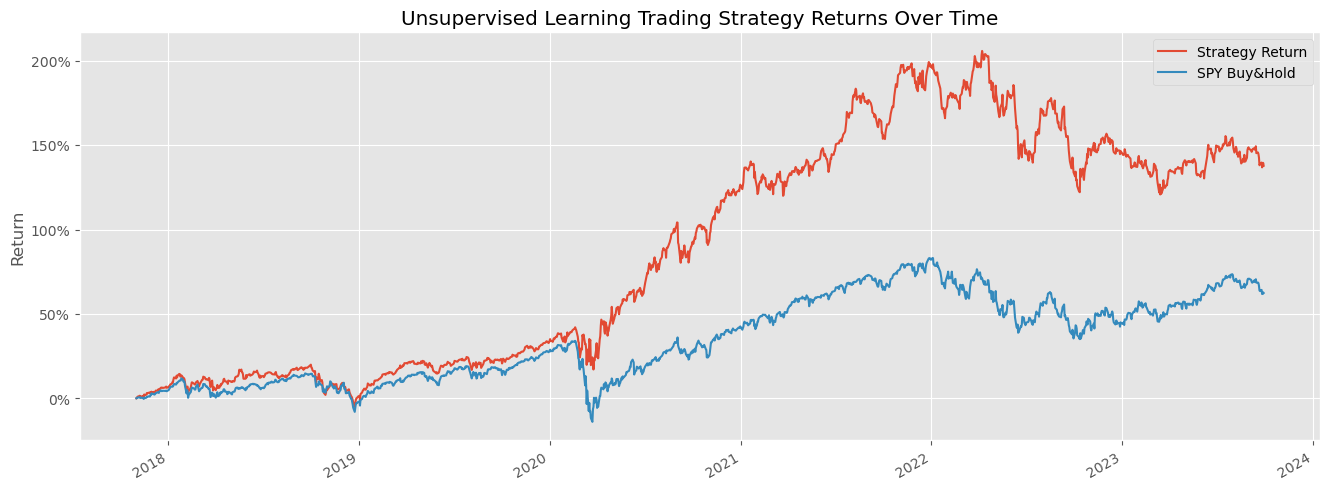

In [179]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


📈 Interpretation:

	1.	From 2017 to around early 2020:
	•	Both strategies perform similarly
	•	Our strategy closely tracks SPY
 
	2.	From 2020 onwards (post-COVID dip):
	•	Our strategy takes off
	•	It continues to gain more and more relative to SPY
	•	While SPY grows steadily, our strategy achieves much higher returns, crossing 200% at the peak
 
	3.	Even in the 2022–2023 downturn:
	•	SPY shows a clear decline 📉
	•	Our strategy also declines but holds more of its gains
→ suggesting better risk-adjusted performance or smarter stock selection